In [1]:
# METHOD = 'GCparagon'
METHOD = 'Griffin'
# METHOD = 'Proposed'
cohorts = ['BRCA_gis', 'CRC_gis', 'healthy_c2i', 'healthy_invitro']

In [2]:
import pickle, os
import numpy as np
from scipy.spatial.distance import jensenshannon
import pandas as pd
import matplotlib.pyplot as plt
from itertools import groupby
from scipy.stats import mannwhitneyu, ranksums, wilcoxon

In [4]:
def check_dic(dic_path):
    dic = {}
    with open(dic_path, 'rb') as f:
        dic = pickle.load(f)
    for key in dic.keys():
        print(key, ' : ', dic[key])

# Inspect Original Bin Coverage

In [4]:
# for cohort in cohorts:
#     print(cohort)
#     original_folder = f'1Mb_2K_bins/Original/{cohort}/'
#     for file_ in os.listdir(original_folder):
#         original = np.load( f'{original_folder}/{file_}' )
#         print(file_[:-4], np.percentile(original, 1) )
#     print()

# Fragment No. Deviation after Correction

In [4]:
fragment_dev_dic = {}

for cohort in cohorts:
    print(cohort)
    original_folder = f'1Mb_2K_bins/Original/{cohort}/'
    corrected_folder = f'1Mb_2K_bins/{METHOD}_Corrected/{cohort}/'
    for file_ in os.listdir(original_folder):
        original = np.sum( np.load( f'{original_folder}/{file_}' ) )
        corrected = np.sum( np.load( f'{corrected_folder}/{file_}' ) )
        diff = abs( round( (corrected - original)/original * 100, 3 ) )
        fragment_dev_dic[file_[:-4]] = diff
        print(f'{file_[:-4]}: {diff}%')
    print()

dic_path = f'Evaluation_Files/{METHOD}/fragment_no_deviation.pkl'
with open(dic_path, 'wb') as f:
    pickle.dump(fragment_dev_dic, f)

BRCA_gis
D14: 4.641%
D19: 6.112%
D23: 10.085%
D7: 9.807%
D9: 0.033%
E10c: 2.885%
E2c: 15.058%
E6c: 9.495%
E7c: 0.109%
E8c: 4.443%

CRC_gis
NCC_CRC-1014_180816-CW-T-ready: 12.877%
NCC_CRC-1279_221015_CW-T-ready: 8.98%
NCC_CRC-1279_241116_CW-T-ready: 13.653%
NCC_CRC-1531_160616_CW-T-ready: 10.804%
NCC_CRC-1531_180119_CW-T-ready: 9.231%
NCC_CRC-512_051015-CW-T-ready: 9.062%
NCC_CRC-512_130114-CW-T-ready: 10.867%
NCC_CRC-519_210114_CW-T-ready: 10.565%
NCC_CRC-809_030915-CW-T-ready: 11.662%
NCC_CRC-809_110914-CW-T-ready: 15.873%
NCC_CRC-986_100215-CW-T-ready: 7.158%
NCC_CRC-986_261016-CW-T-ready: 6.445%

healthy_c2i
WHC556.sort: 15.418%
WHC557.sort: 12.046%
WHC558.sort: 15.745%
WHC559.sort: 6.491%
WHC560.sort: 14.28%
WHC561.sort: 17.049%
WHC562.sort: 7.933%
WHC563.sort: 9.639%
WHC564.sort: 10.641%
WHC565.sort: 12.559%
WHC566.sort: 13.698%
WHC567.sort: 6.96%
WHC568.sort: 7.467%
WHC569.sort: 6.496%
WHC570.sort: 11.188%
WHC571.sort: 0.049%
WHC572.sort: 18.142%

healthy_invitro
WHC1384: 7.607%


# Reference GC Profile Deviation After Correction

In [19]:
original_GC_array_dic, correct_GC_array_dic = {}, {}

def interpolate_zero_elements(array):
    first_non_zero_index = np.argmax(array != 0)
    last_non_zero_index = len(array) - 1 - np.argmax(array[::-1] != 0)
    inner_array = array[first_non_zero_index:last_non_zero_index + 1]
    non_zero_indices = np.nonzero(inner_array)[0]
    zero_indices = np.where(inner_array == 0)[0]
    inner_array[zero_indices] = np.interp(zero_indices, non_zero_indices, inner_array[non_zero_indices])
    array[first_non_zero_index:last_non_zero_index + 1] = inner_array
    return array

def process_length_level(len_sample):
    processed_sample = np.zeros( len_sample.shape )
    for i in range(len_sample.shape[0]):
        processed_sample[i, :] = interpolate_zero_elements(len_sample[i, :])
    return processed_sample

def load_folder(folder, sample_type):
    global original_GC_array_dic, correct_GC_array_dic
    for file_ in os.listdir(folder):
        if file_.endswith('.npy')==True:
            GC_array = np.load(folder + '/' + file_)
            if sample_type==0:
                original_GC_array_dic[file_[:-4]] = process_length_level(GC_array)
            elif sample_type==1:
                correct_GC_array_dic[file_[:-4]] = process_length_level(GC_array)

original_folder = f'350bp_Length_101_GC_content/Original/'
for cohort in cohorts:
    load_folder(f'{original_folder}/{cohort}', 0)
                     
correct_folder = f'350bp_Length_101_GC_content/{METHOD}_Corrected/'
for cohort in cohorts:
    load_folder(f'{correct_folder}/{cohort}', 1)

ref_GC_array = np.load('ref_genome_GC.npy') # (350, 101)
ref_len_GC_array = process_length_level(ref_GC_array)

D7


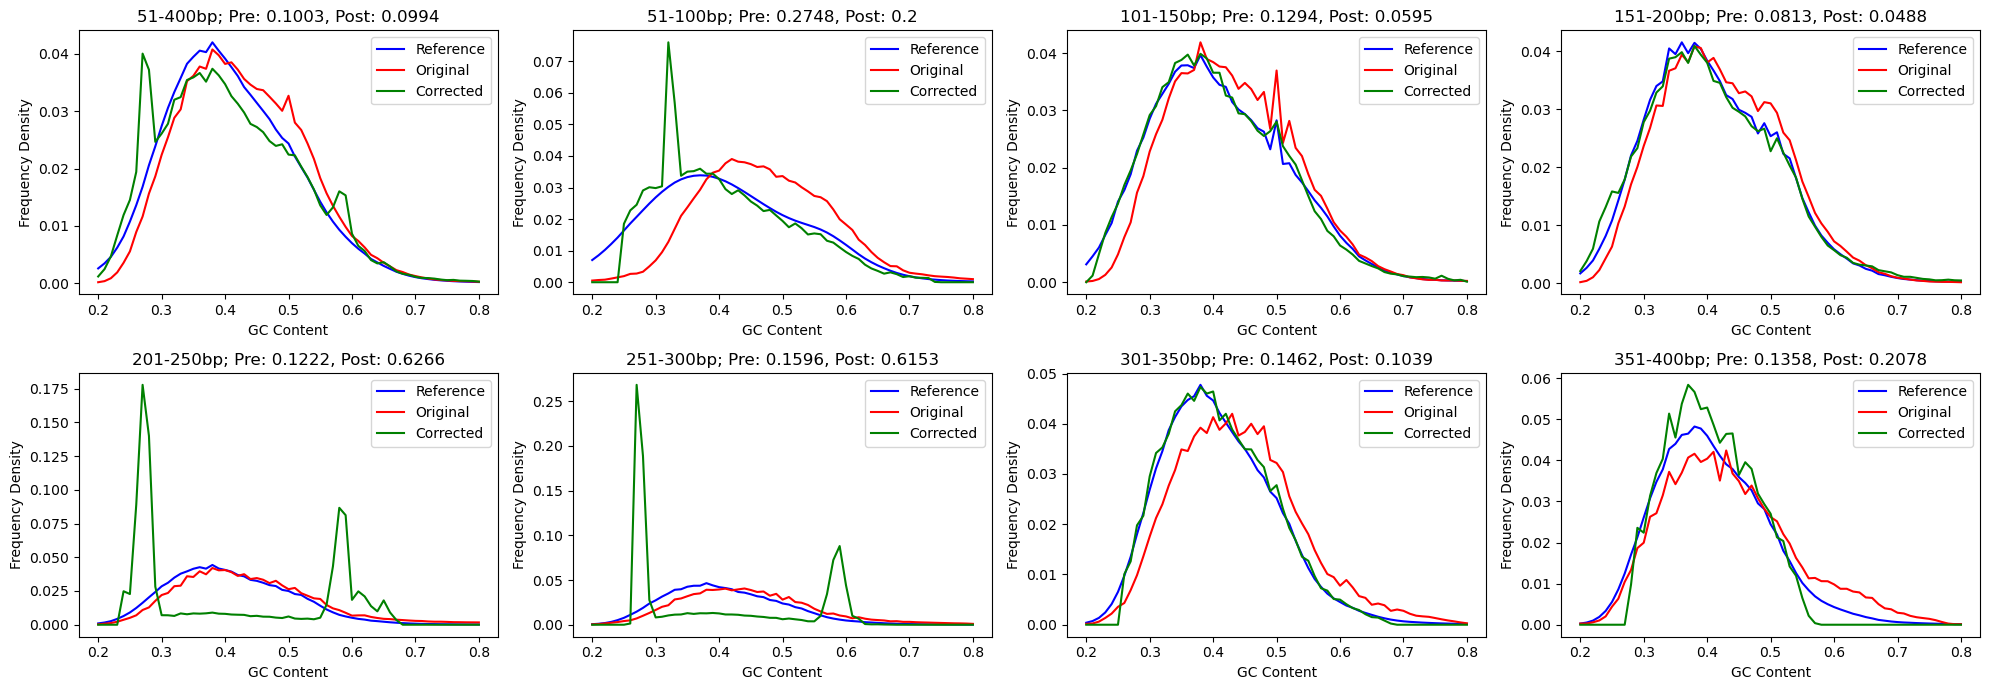

E6c


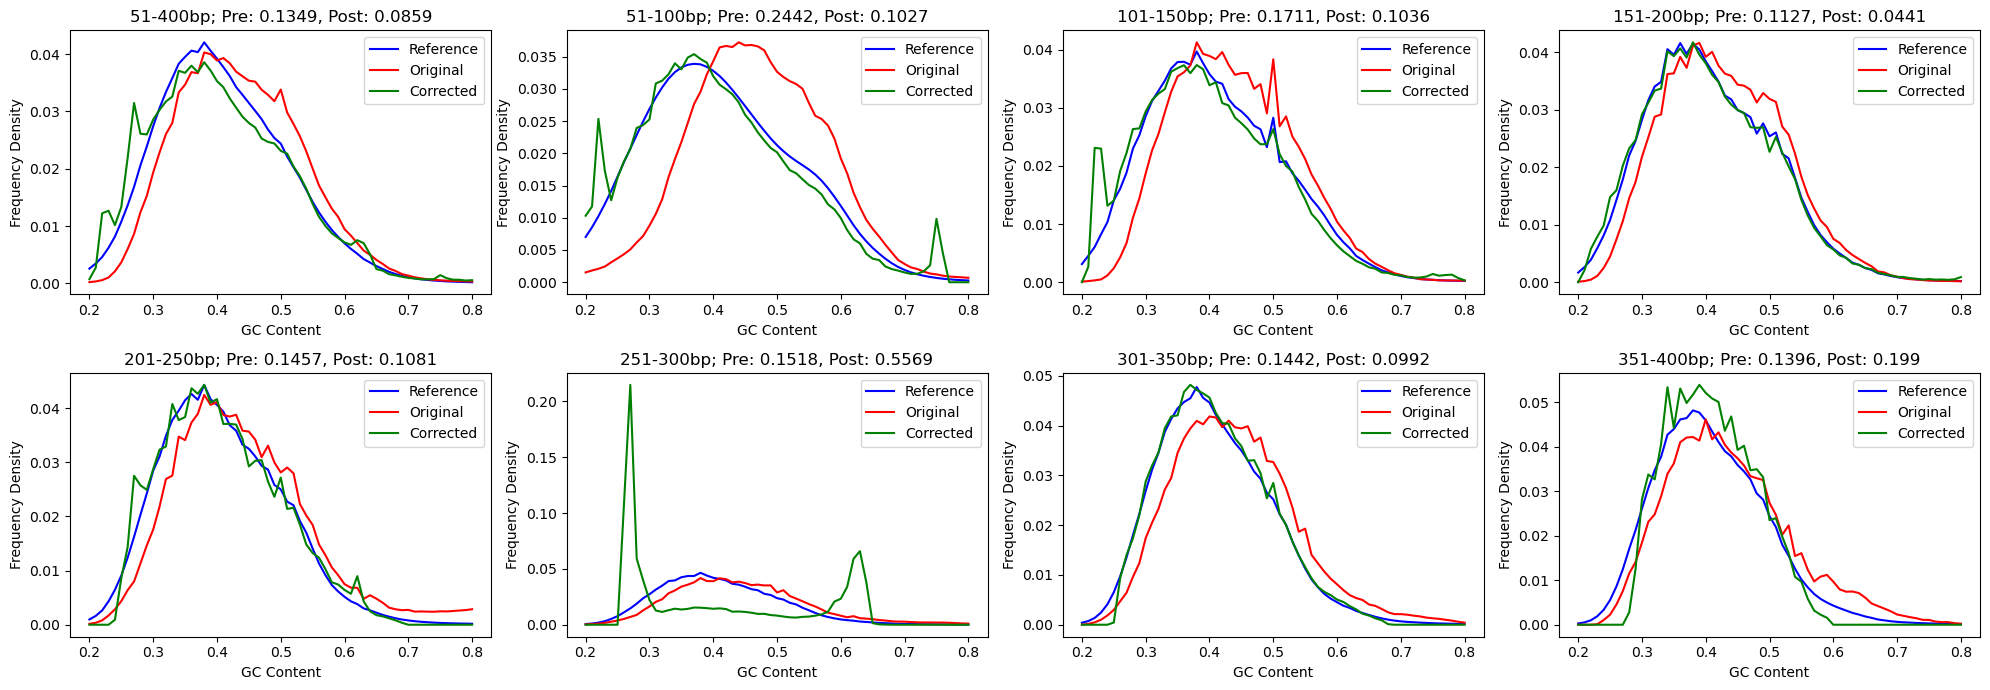

NCC_CRC-1279_221015_CW-T-ready


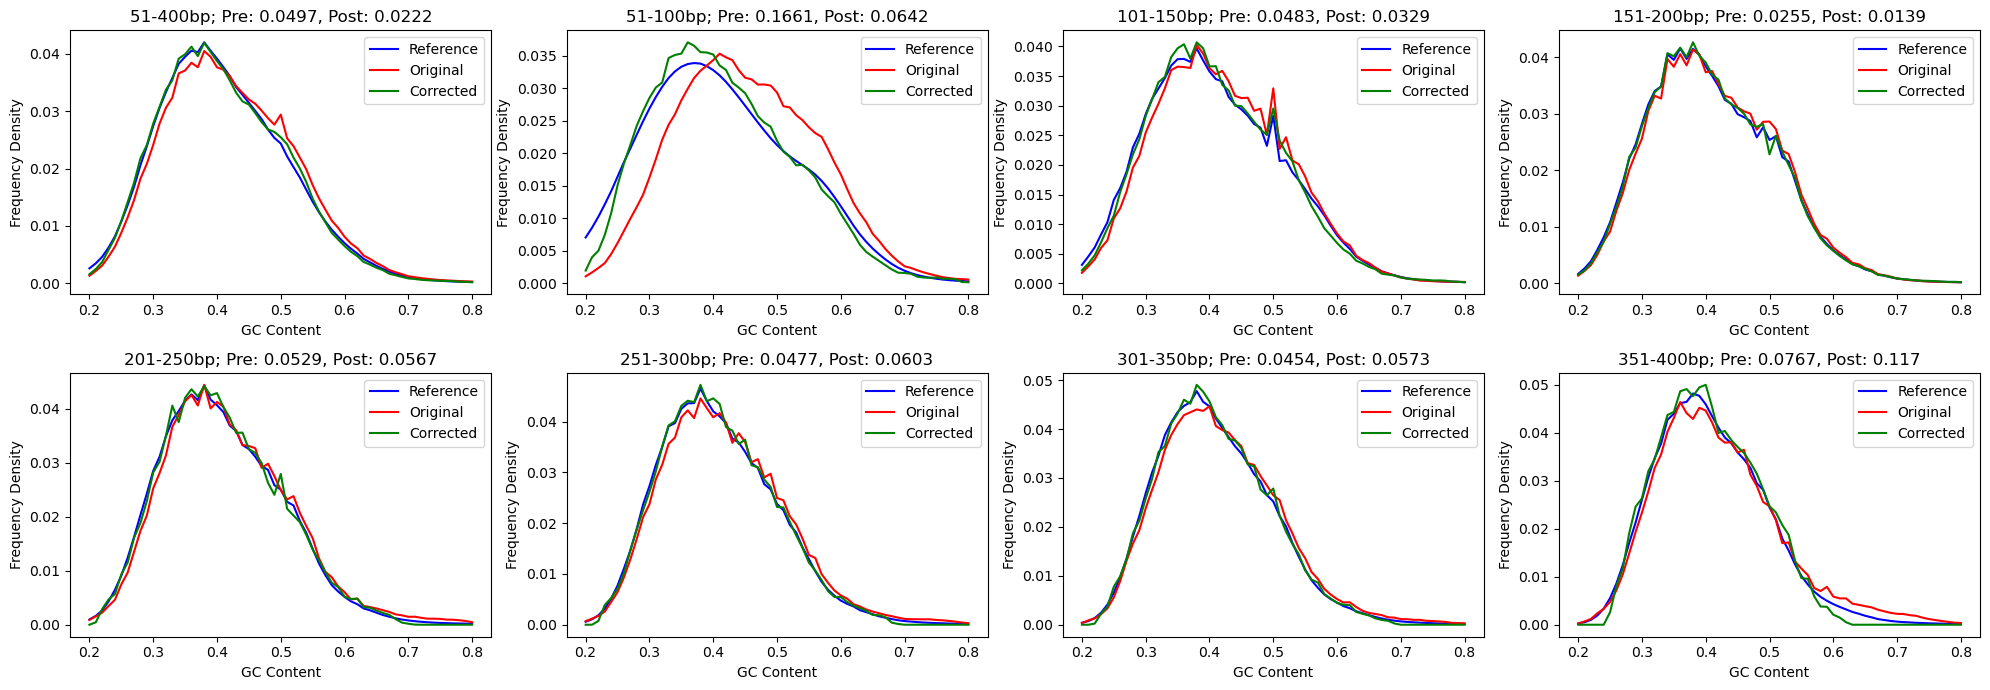

NCC_CRC-512_051015-CW-T-ready


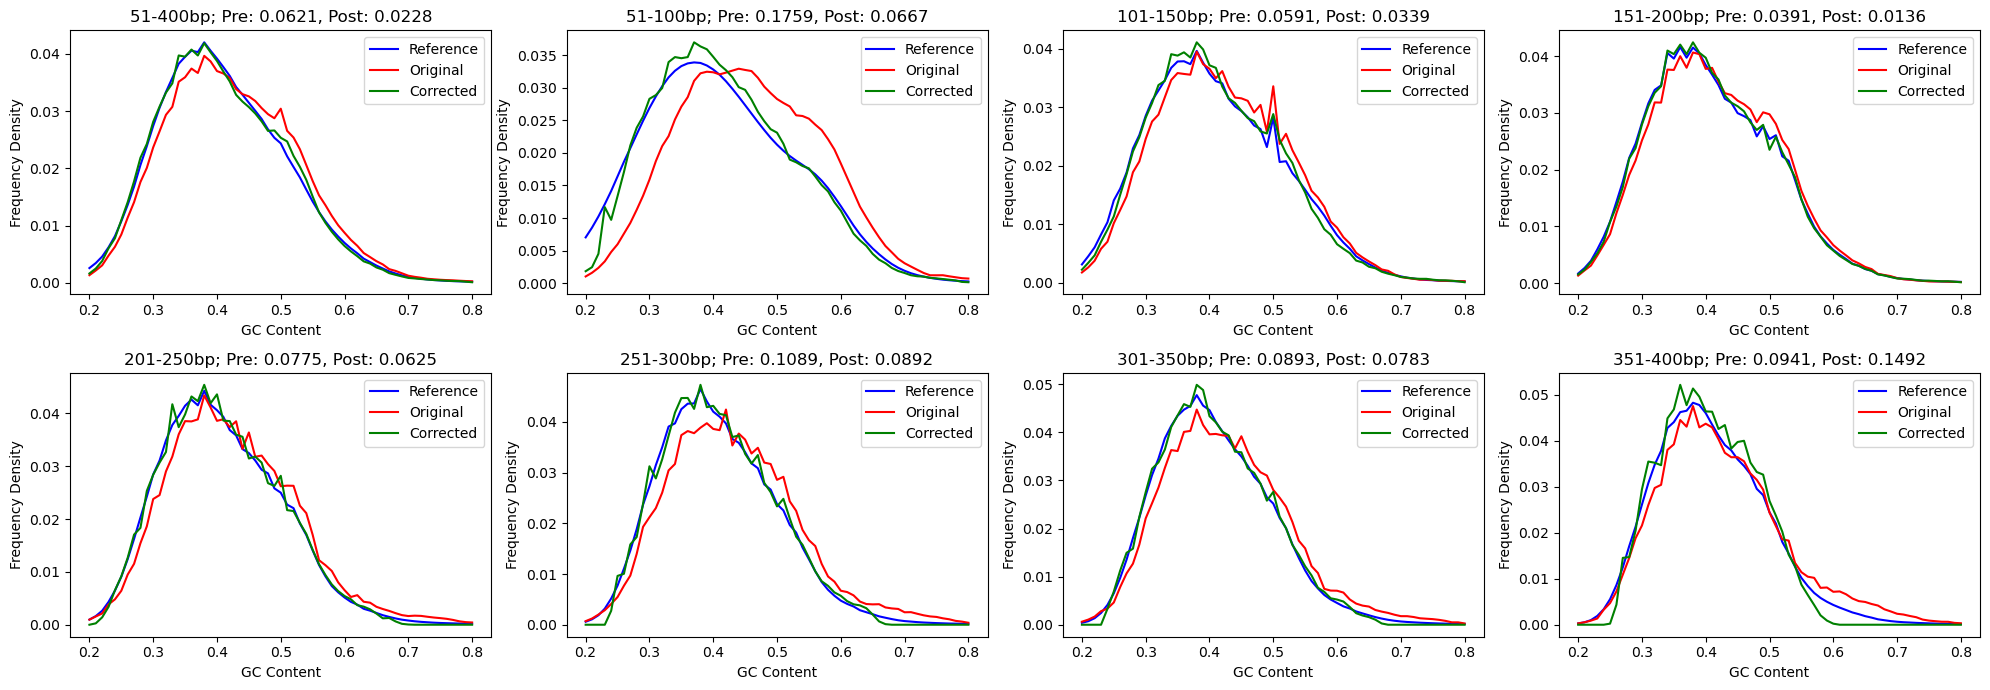

NCC_CRC-809_110914-CW-T-ready


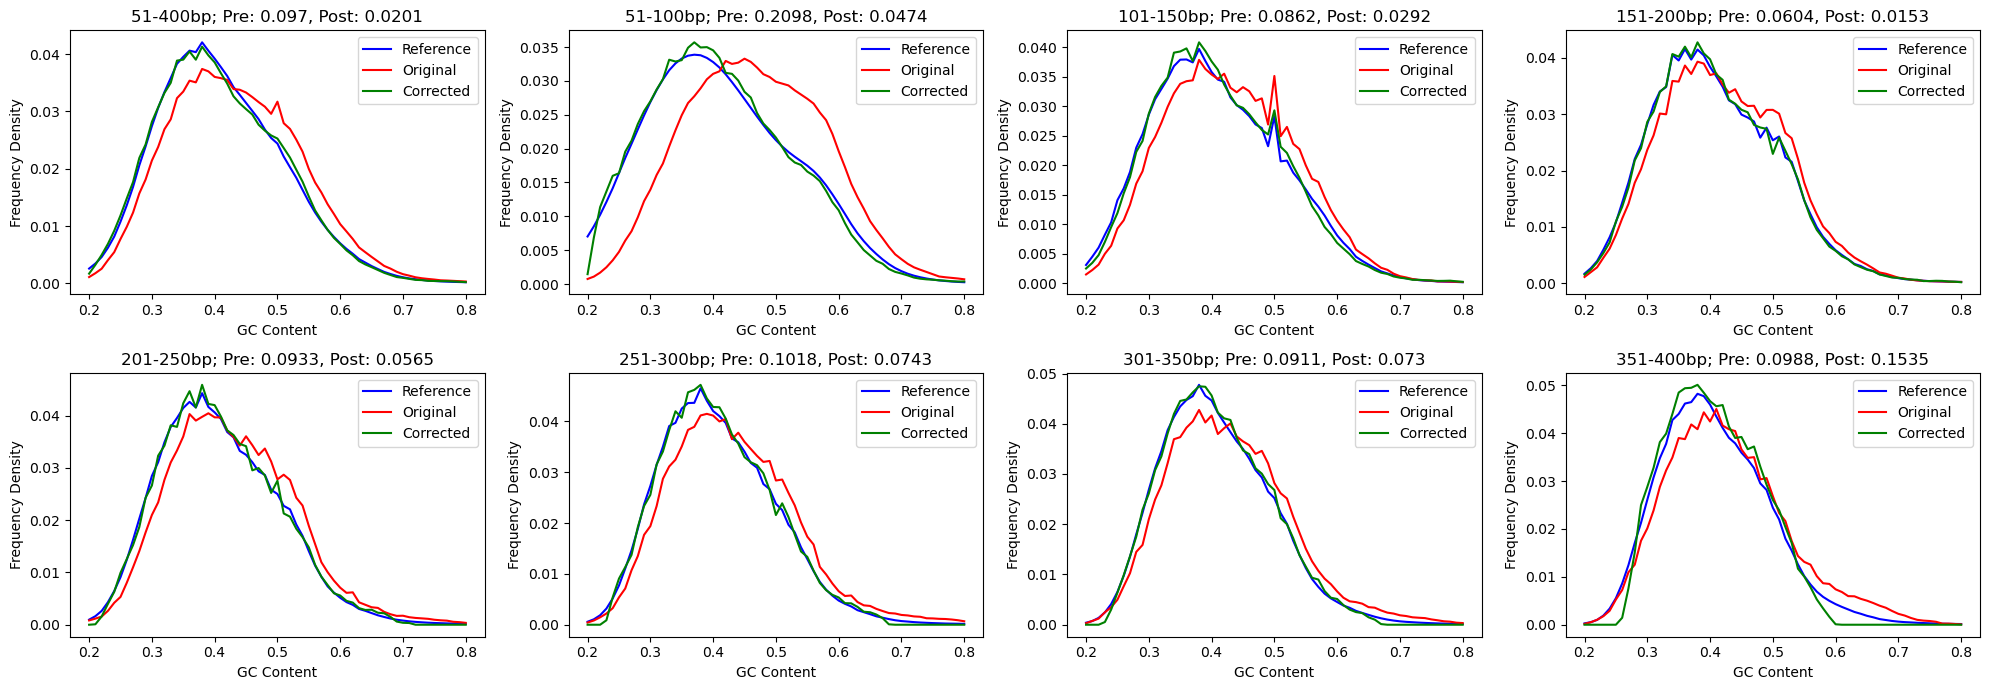

WHC557.sort


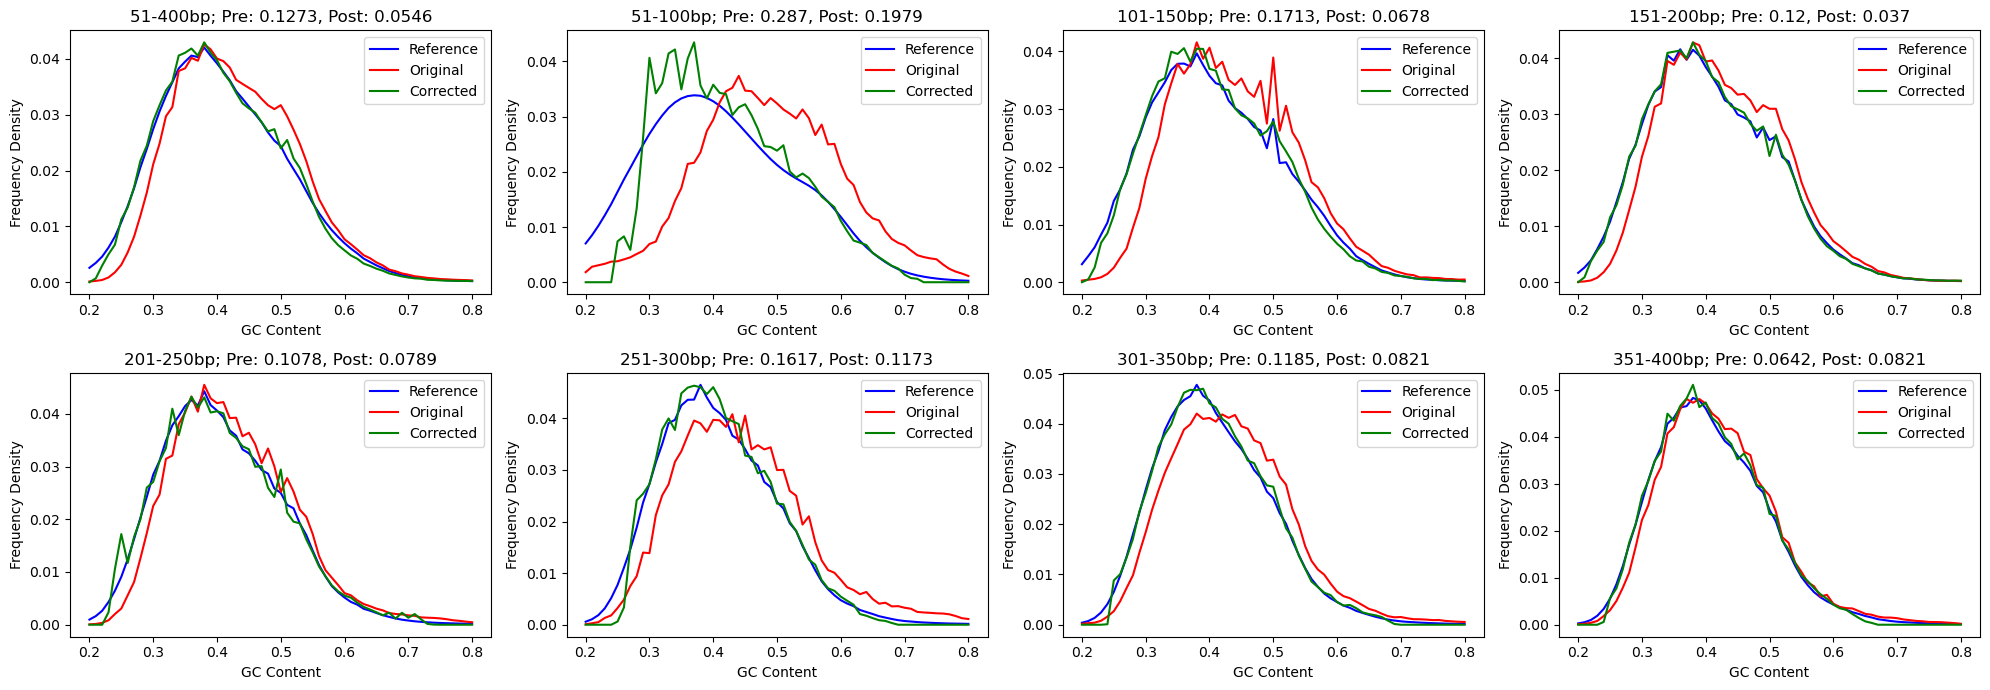

WHC561.sort


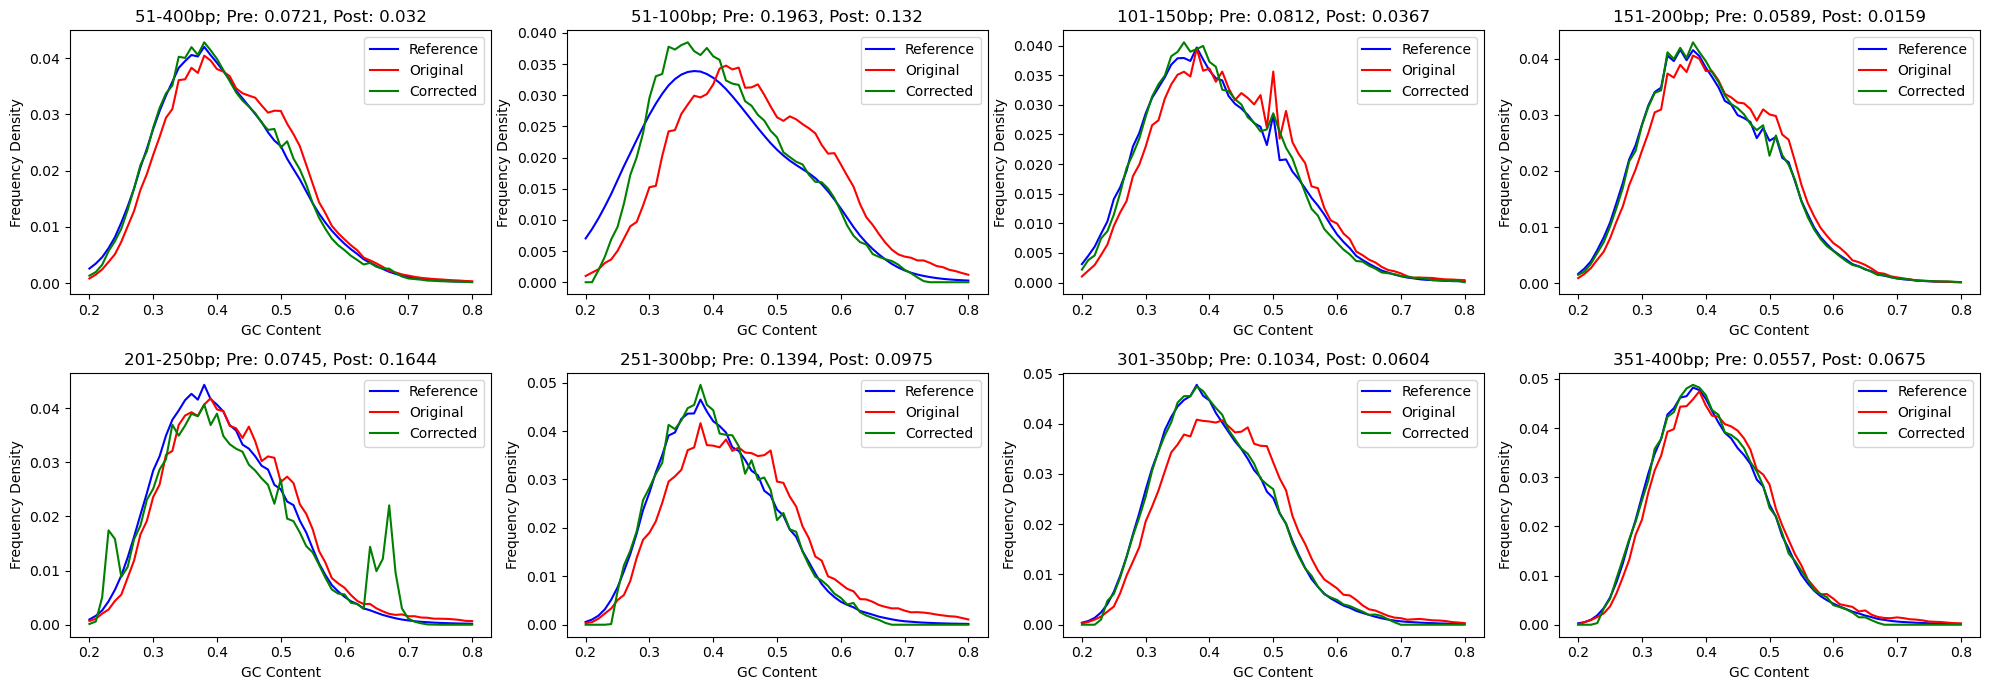

WHC565.sort


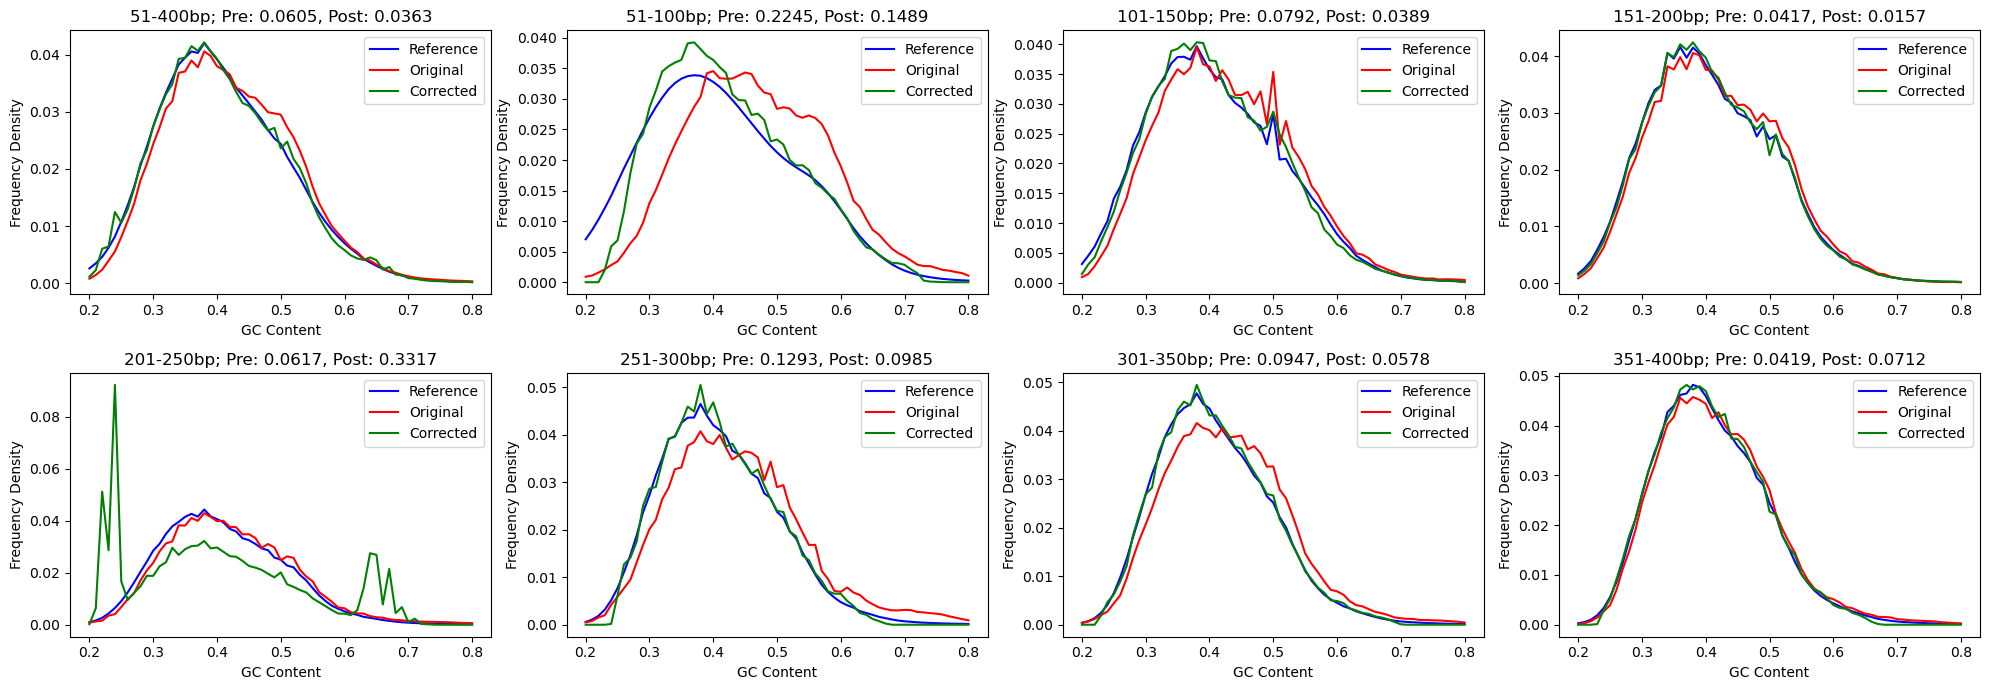

WHC569.sort


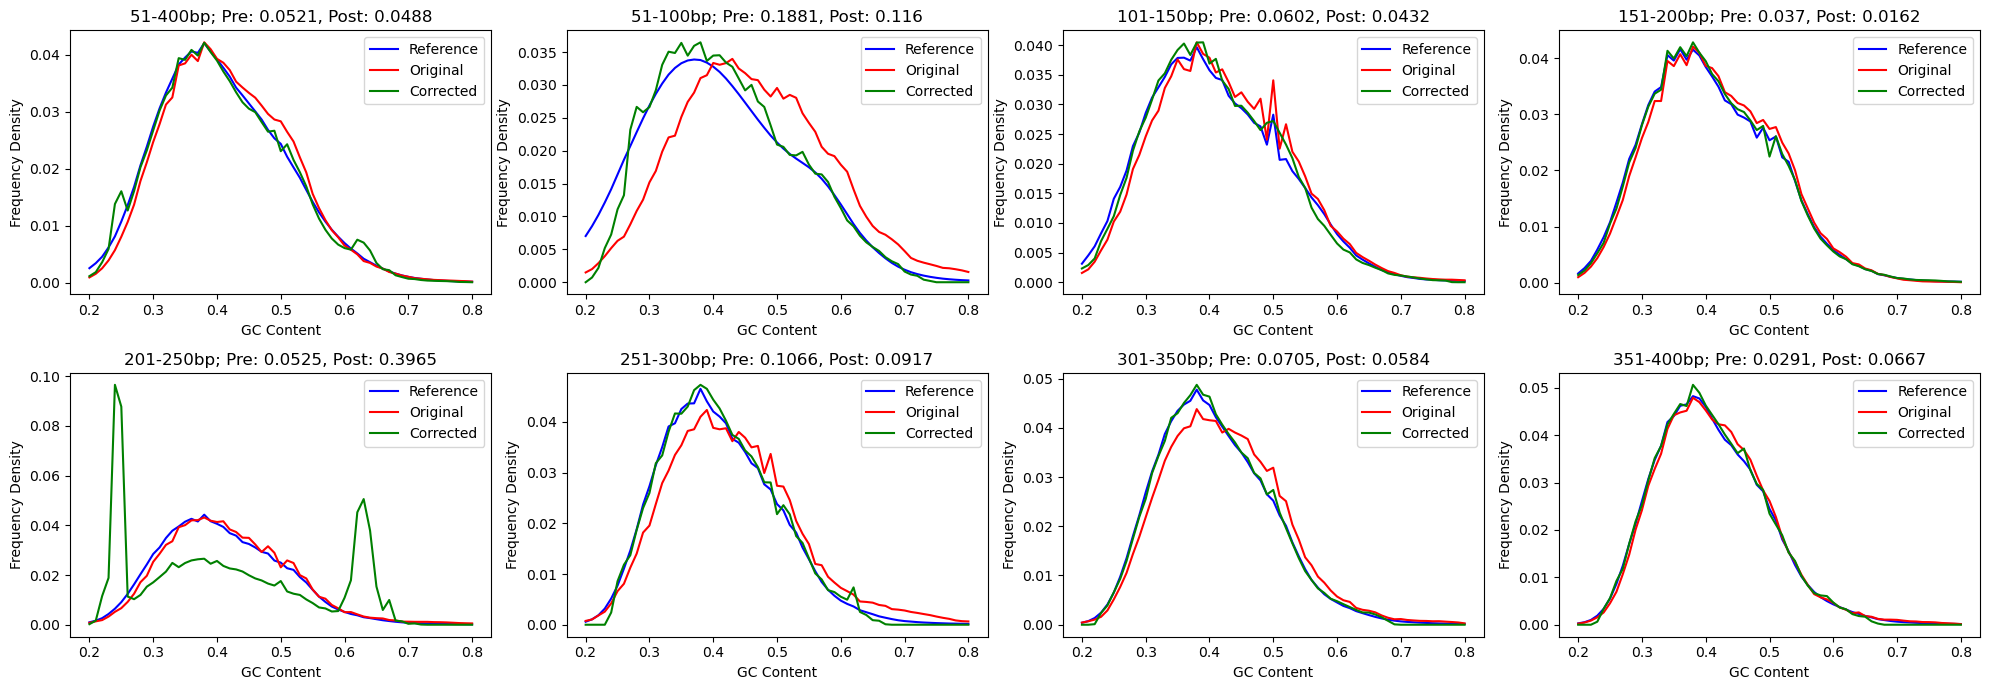

WHC1384


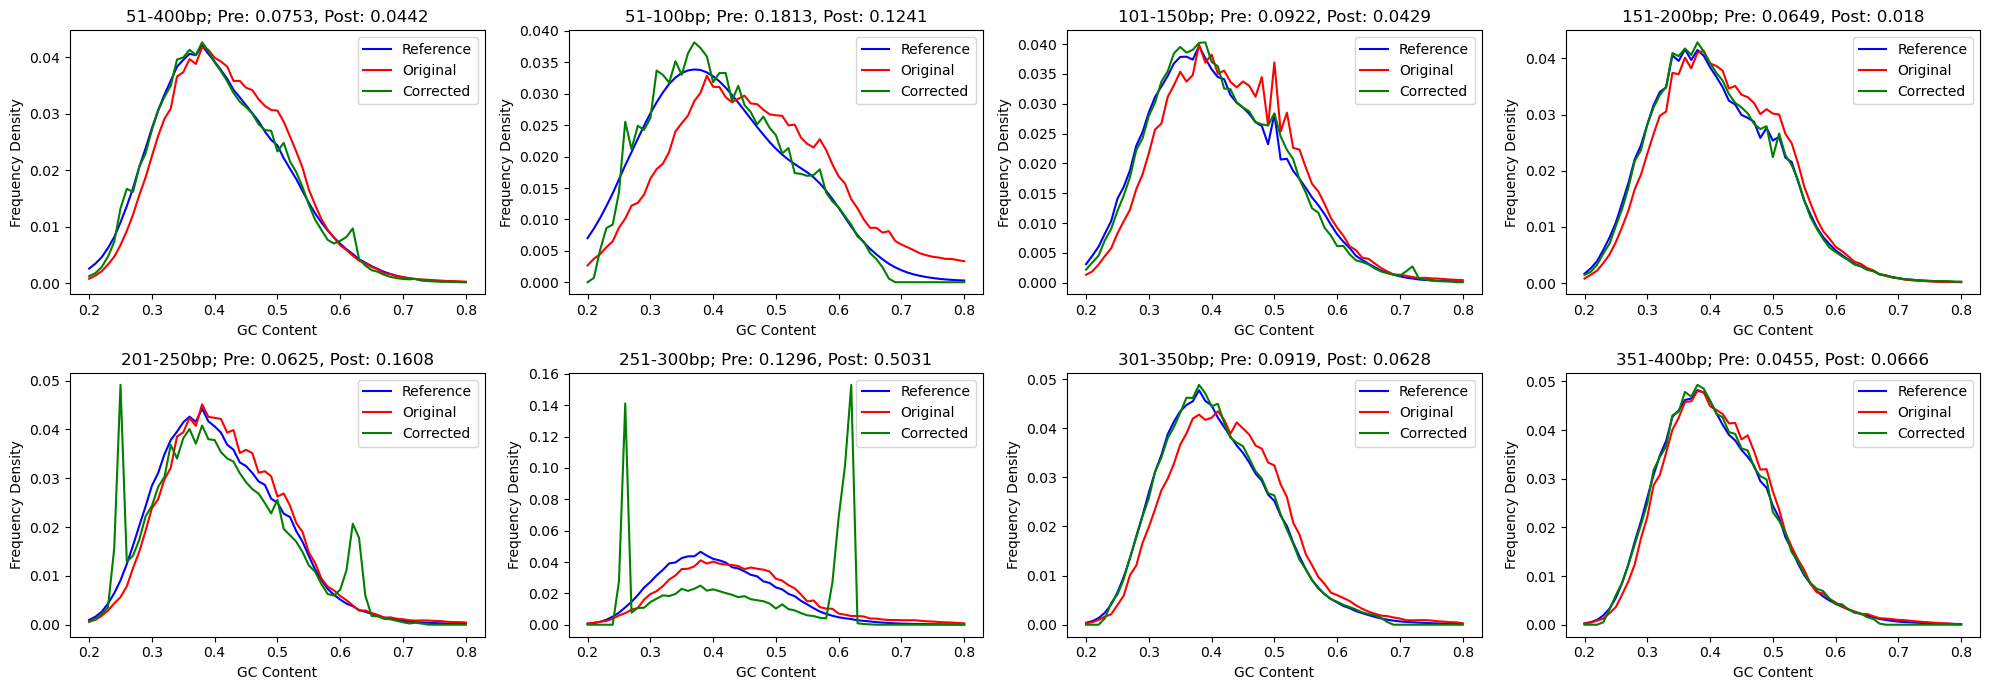

WHC1388


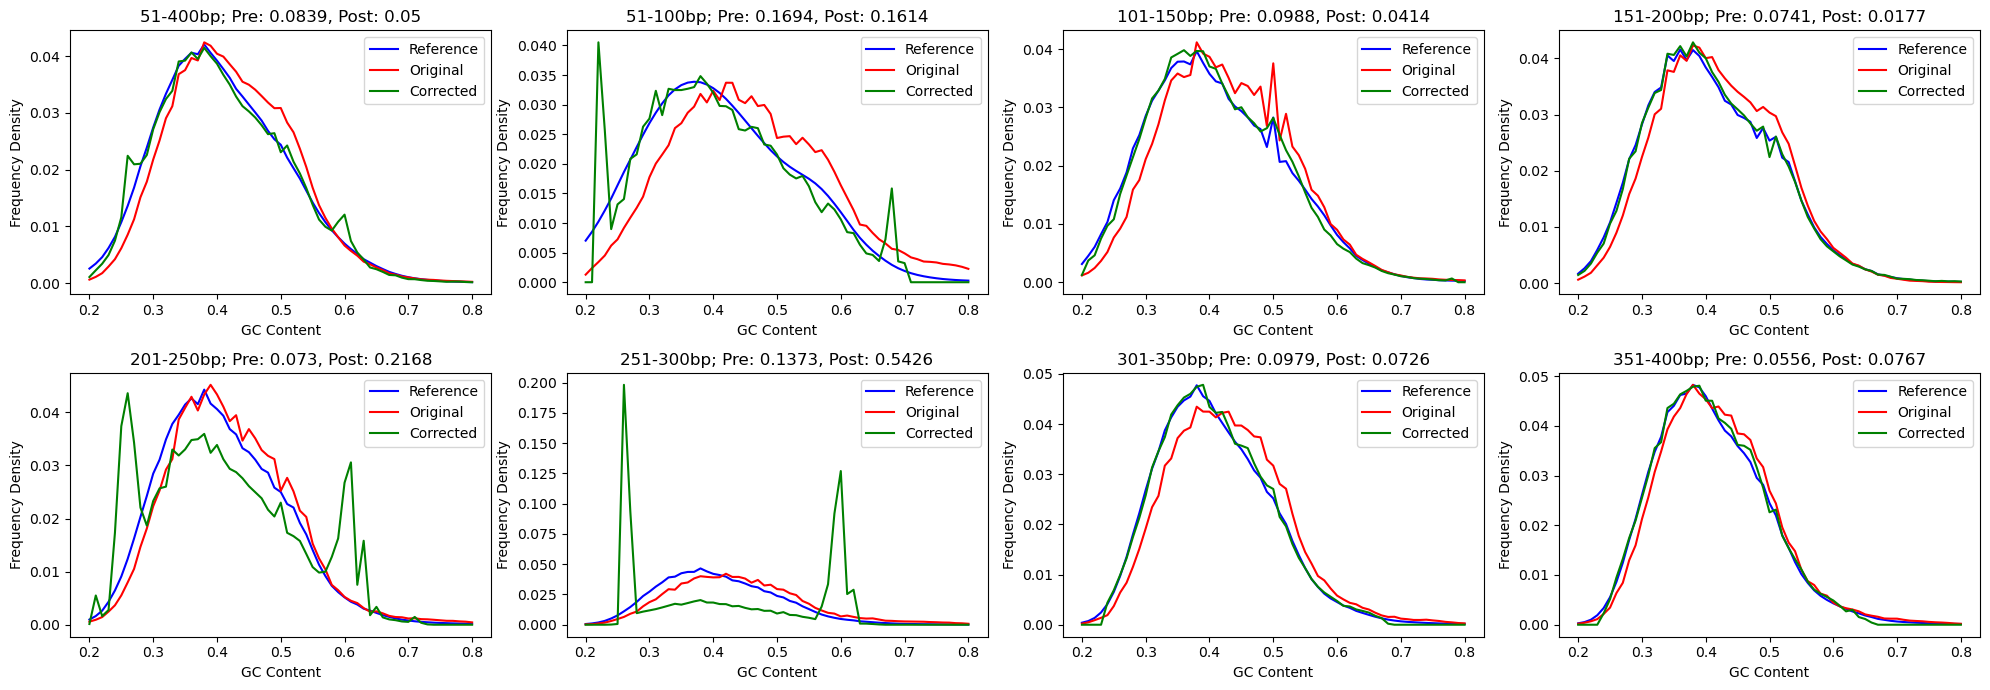

WHC1392


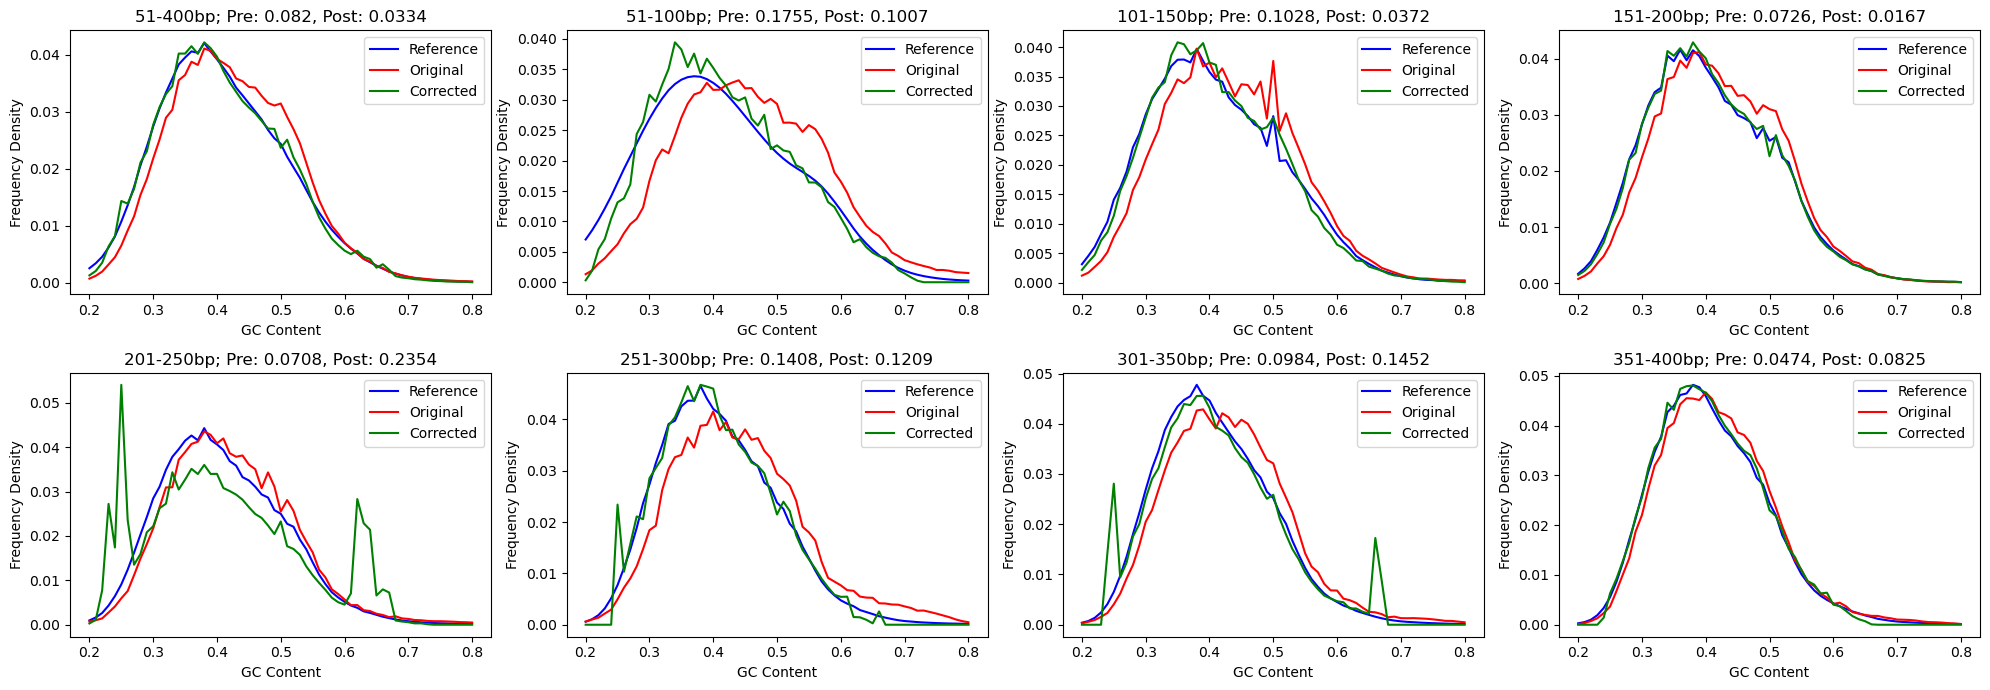

In [20]:
ref_original_JS_dic, ref_correct_JS_dic = {}, {}

def derive_Y(sample, start_len, end_len):
    len_inds = [(i-51) for i in range(start_len, end_len+1)]
    Y = np.sum(sample[len_inds, 20:81], axis=0) ####
    Y = Y / np.sum(Y)
    return Y


def get_JS(sample):
    global correct_GC_array_dic, ref_len_GC_array, ref_correct_JS_dic
    len_groups = [[51, 400], [51, 100], [101, 150], [151, 200], [201, 250], [251, 300], [301, 350], [351, 400]]
    for len_group in len_groups:
        ref_Y = derive_Y(ref_len_GC_array, len_group[0], len_group[1])
        original_Y = derive_Y(original_GC_array_dic[sample], len_group[0], len_group[1])
        correct_Y = derive_Y(correct_GC_array_dic[sample], len_group[0], len_group[1])
        ref_original_diff = round(jensenshannon(ref_Y, original_Y, base=2), 4)
        ref_correct_diff = round(jensenshannon(ref_Y, correct_Y, base=2), 4)
        key = f'{sample}: {len_group[0]}-{len_group[1]}'
        ref_correct_JS_dic[key] = ref_correct_diff
        ref_original_JS_dic[key] = ref_original_diff


def plot_GC_curve(sample):
    global correct_GC_array_dic, ref_len_GC_array, ref_correct_JS_dic
    print(sample)
    len_groups = [[51, 400], [51, 100], [101, 150], [151, 200], [201, 250], [251, 300], [301, 350], [351, 400]]
    X = [(i/100.0) for i in range(20, 81)] #####
    fig, axes = plt.subplots(2, 4, figsize=(20, 7))
    i = 0
    
    for len_group in len_groups:
        ref_Y = derive_Y(ref_len_GC_array, len_group[0], len_group[1])
        original_Y = derive_Y(original_GC_array_dic[sample], len_group[0], len_group[1])
        correct_Y = derive_Y(correct_GC_array_dic[sample], len_group[0], len_group[1])
        ref_original_diff = round(jensenshannon(ref_Y, original_Y, base=2), 4)
        ref_correct_diff = round(jensenshannon(ref_Y, correct_Y, base=2), 4)
        key = f'{sample}: {len_group[0]}-{len_group[1]}'
        ref_correct_JS_dic[key] = ref_correct_diff
        ref_original_JS_dic[key] = ref_original_diff
        row = i // 4
        col = i % 4 
        ax = axes[row, col]
        ax.plot(X, ref_Y, label='Reference', color='blue')
        ax.plot(X, original_Y, label='Original', color='red')
        ax.plot(X, correct_Y, label='Corrected', color='Green')
        ax.set_title(f'{len_group[0]}-{len_group[1]}bp; Pre: {ref_original_diff}, Post: {ref_correct_diff}')
        ax.set_xlabel('GC Content')
        ax.set_ylabel('Frequency Density')
        ax.legend()
        i += 1
    plt.tight_layout()
    plt.show()

plot_cnt = 1
for sample in original_GC_array_dic.keys():
    if plot_cnt%4==0:
        plot_GC_curve(sample)
    else:
        get_JS(sample)
    plot_cnt += 1
# plot_cnt = 1
# for sample in original_GC_array_dic.keys():
#     plot_GC_curve(sample)
    
dic_path = f'Evaluation_Files/{METHOD}/reference_JS_divergence.pkl'
with open(dic_path, 'wb') as f:
    pickle.dump(ref_correct_JS_dic, f)

dic_path = f'Evaluation_Files/Original/reference_JS_divergence.pkl'
with open(dic_path, 'wb') as f:
    pickle.dump(ref_original_JS_dic, f)

In [8]:
dic_path = f'Evaluation_Files/{METHOD}/reference_JS_divergence.pkl'
check_dic(dic_path)

D14: 51-400  :  0.035
D14: 51-100  :  0.124
D14: 101-150  :  0.049
D14: 151-200  :  0.021
D14: 201-250  :  0.106
D14: 251-300  :  0.088
D14: 301-350  :  0.08
D14: 351-400  :  0.116
D19: 51-400  :  0.048
D19: 51-100  :  0.243
D19: 101-150  :  0.07
D19: 151-200  :  0.029
D19: 201-250  :  0.089
D19: 251-300  :  0.092
D19: 301-350  :  0.086
D19: 351-400  :  0.113
D23: 51-400  :  0.041
D23: 51-100  :  0.139
D23: 101-150  :  0.05
D23: 151-200  :  0.026
D23: 201-250  :  0.116
D23: 251-300  :  0.11
D23: 301-350  :  0.106
D23: 351-400  :  0.133
D7: 51-400  :  0.0726
D7: 51-100  :  0.2804
D7: 101-150  :  0.1021
D7: 151-200  :  0.0555
D7: 201-250  :  0.1232
D7: 251-300  :  0.1592
D7: 301-350  :  0.1491
D7: 351-400  :  0.1355
D9: 51-400  :  0.047
D9: 51-100  :  0.213
D9: 101-150  :  0.056
D9: 151-200  :  0.028
D9: 201-250  :  0.072
D9: 251-300  :  0.063
D9: 301-350  :  0.056
D9: 351-400  :  0.09
E10c: 51-400  :  0.036
E10c: 51-100  :  0.134
E10c: 101-150  :  0.048
E10c: 151-200  :  0.022
E10c: 201

# Cancer All Fragment Lengths Coverage Profile Visualization

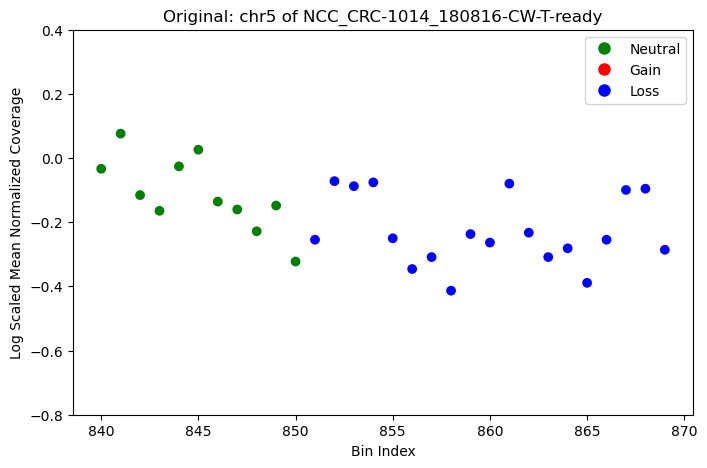

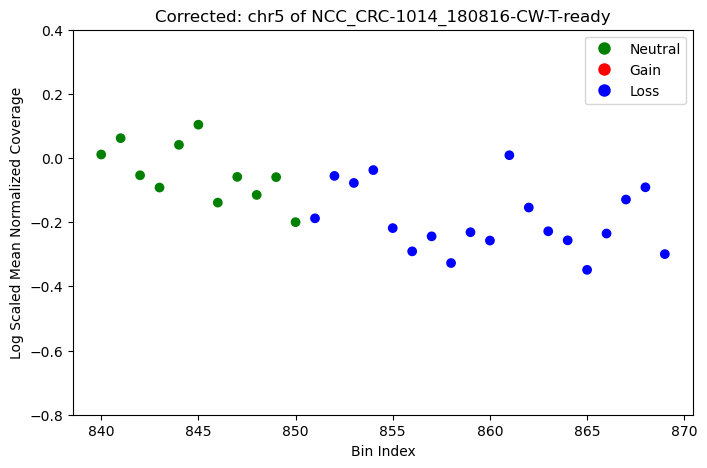

..................................................................................................................


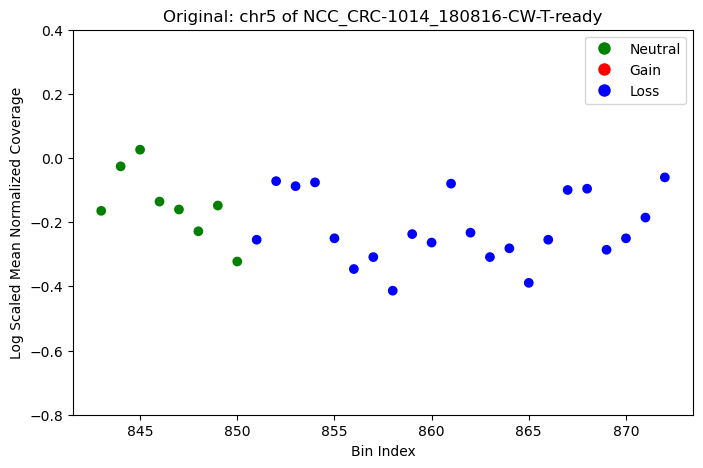

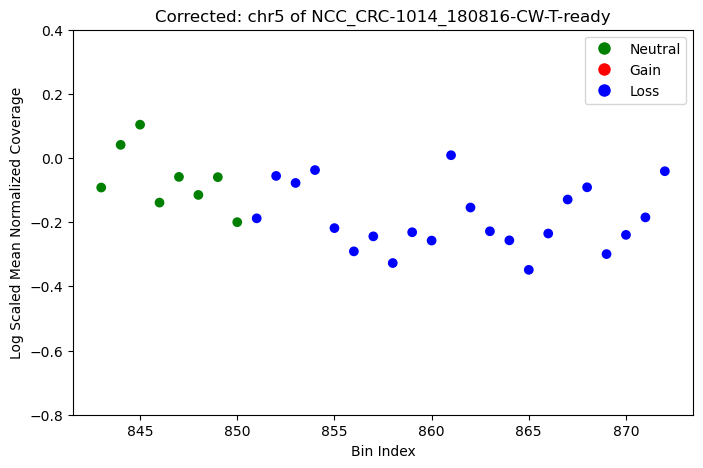

..................................................................................................................


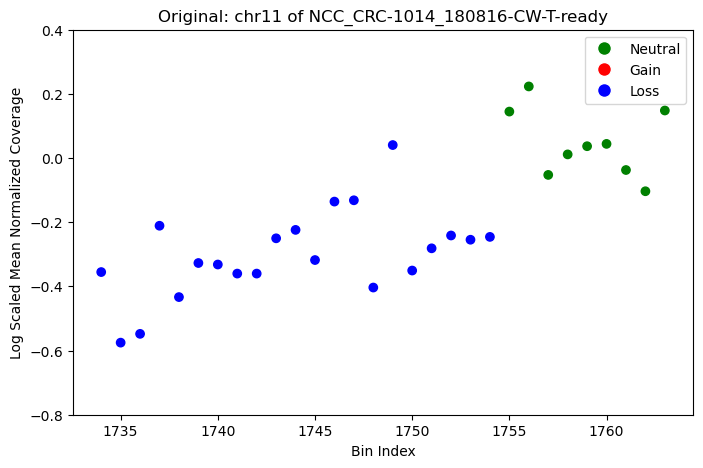

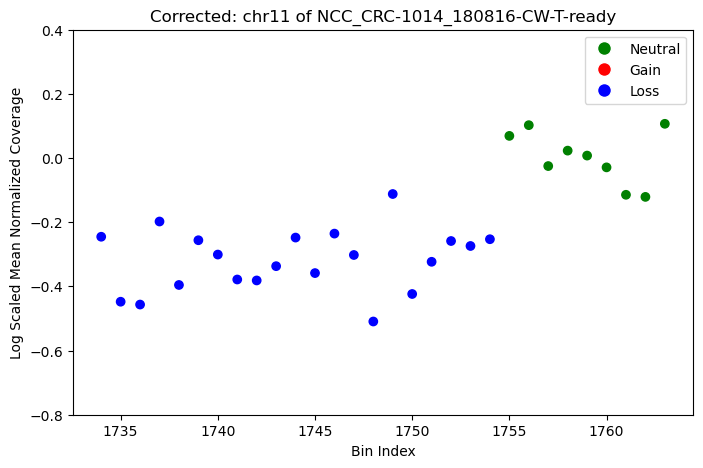

..................................................................................................................


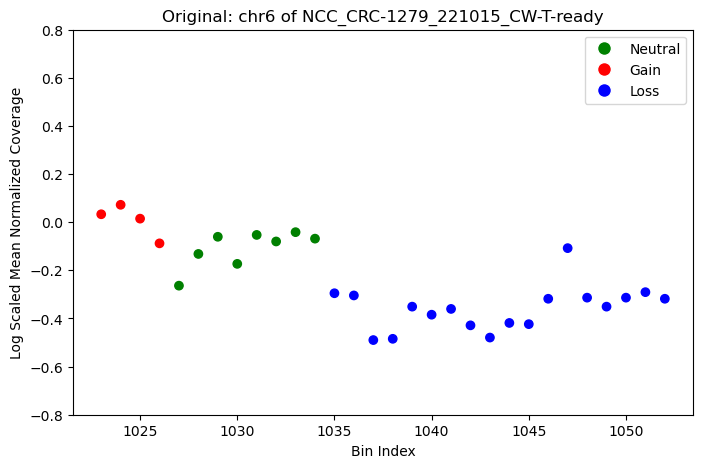

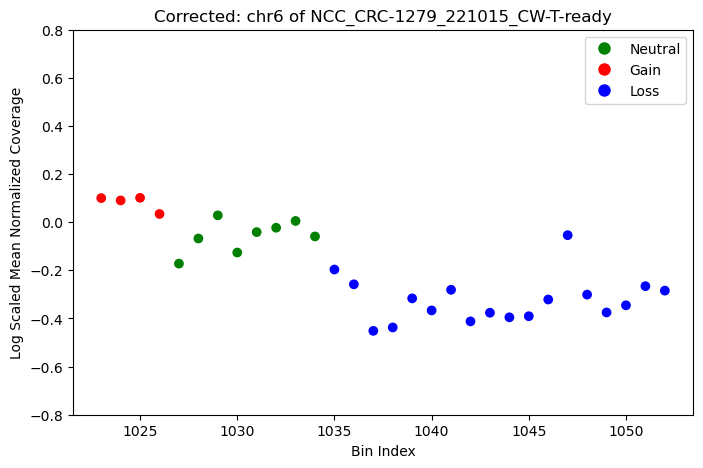

..................................................................................................................


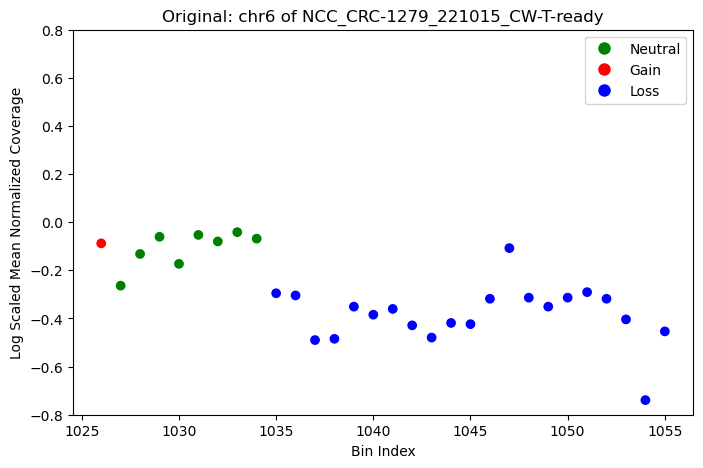

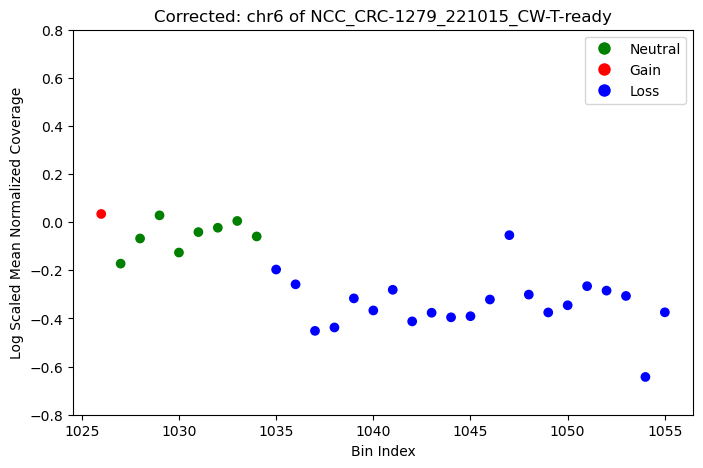

..................................................................................................................


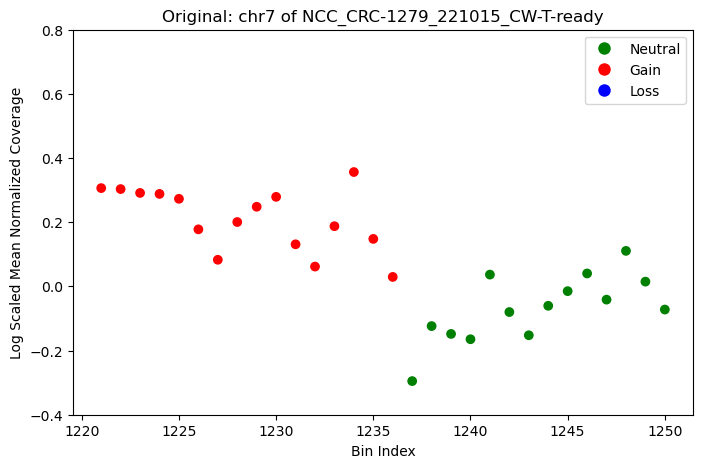

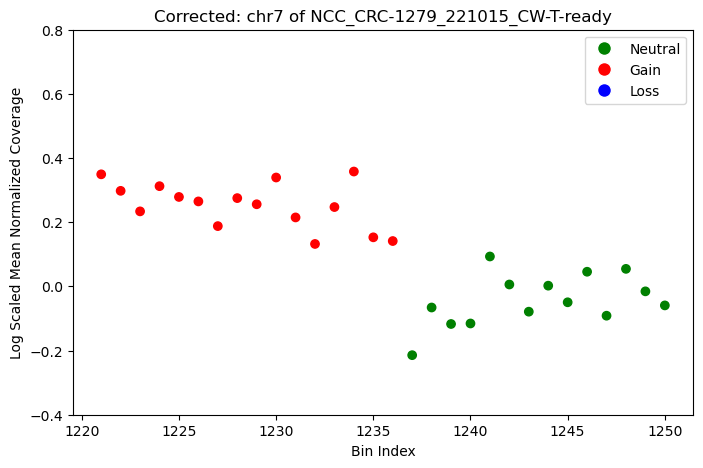

..................................................................................................................


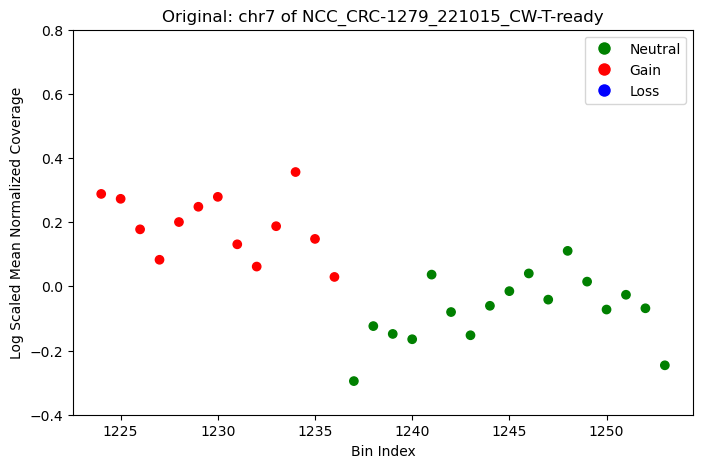

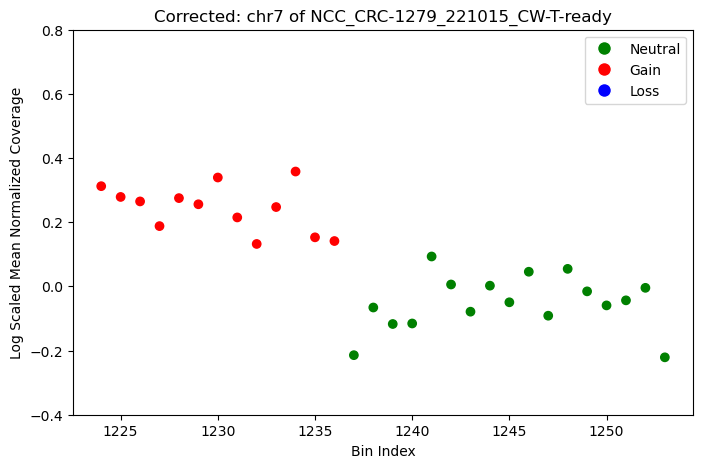

..................................................................................................................


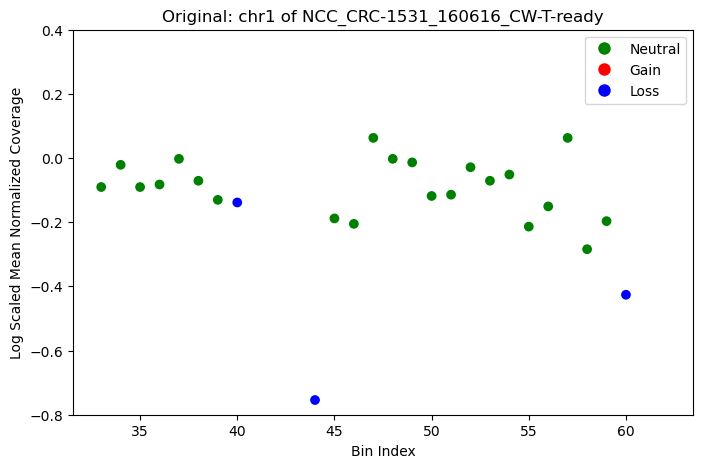

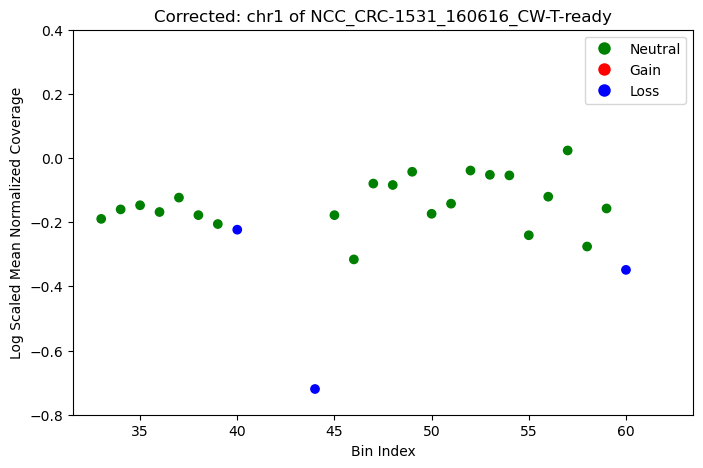

..................................................................................................................


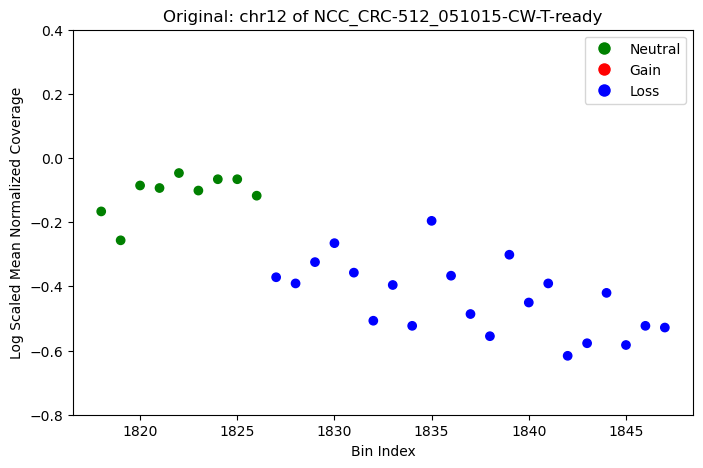

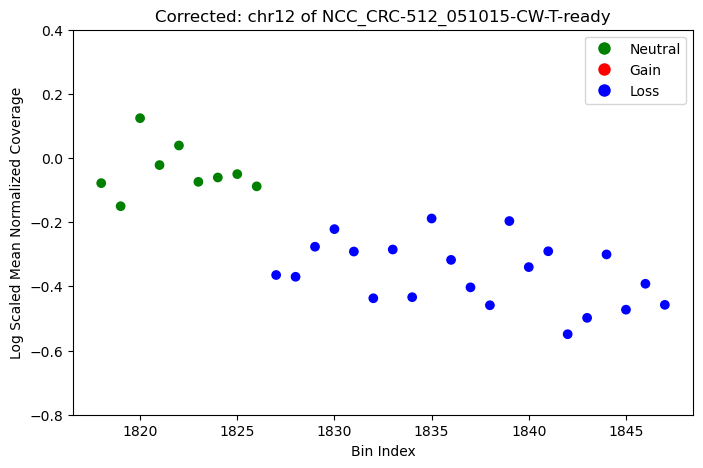

..................................................................................................................


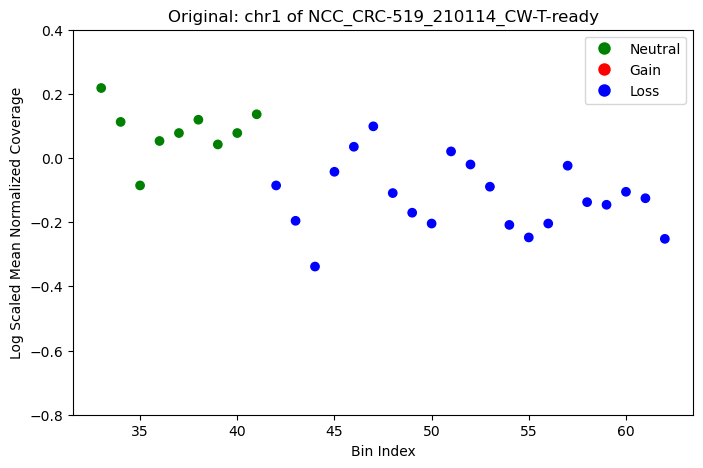

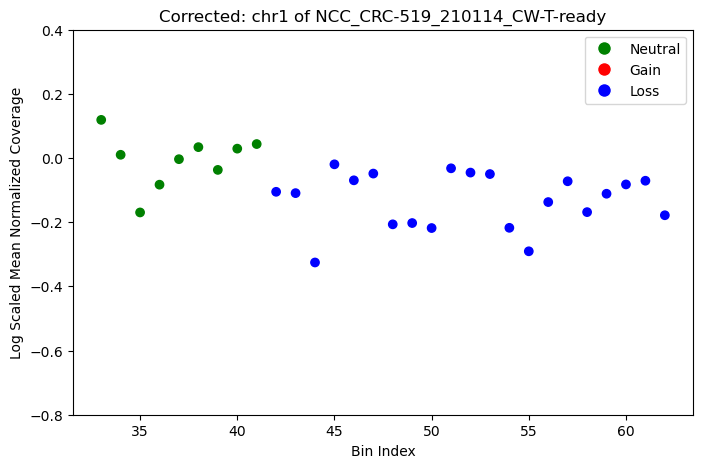

..................................................................................................................


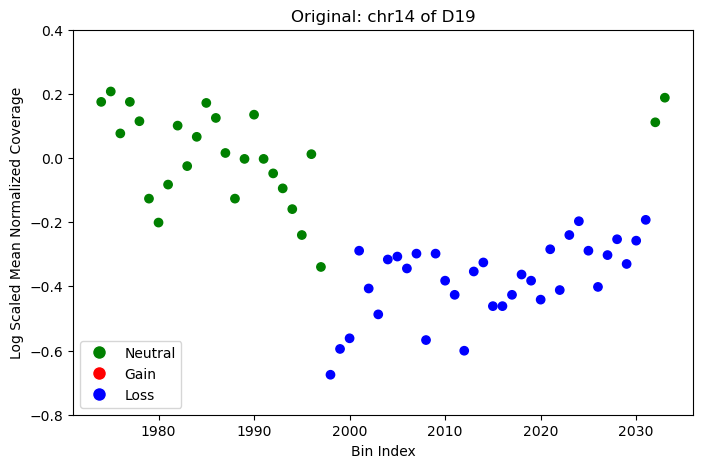

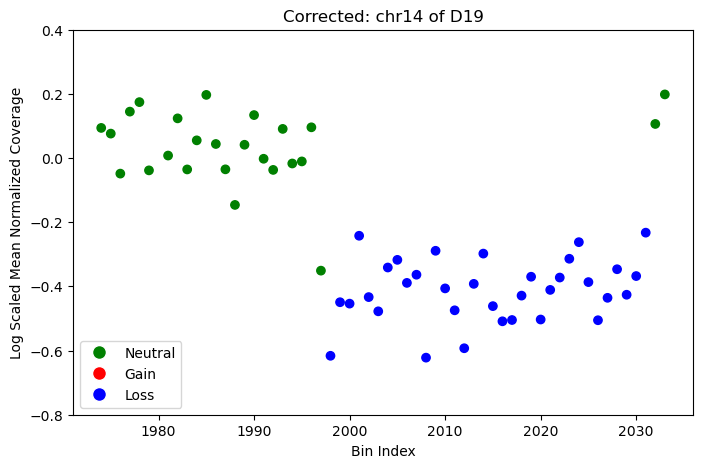

..................................................................................................................


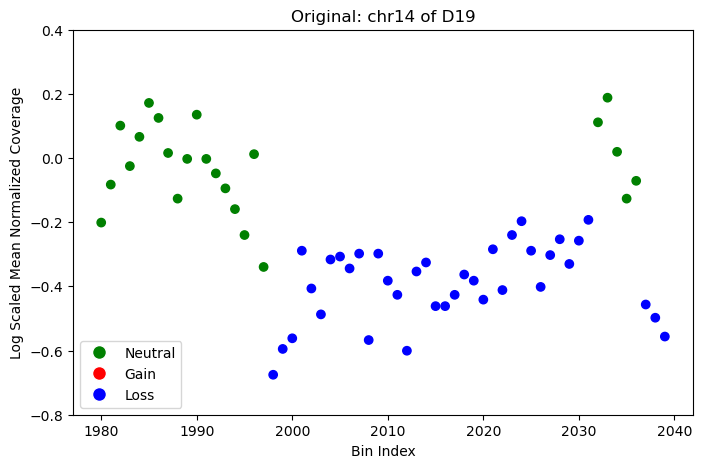

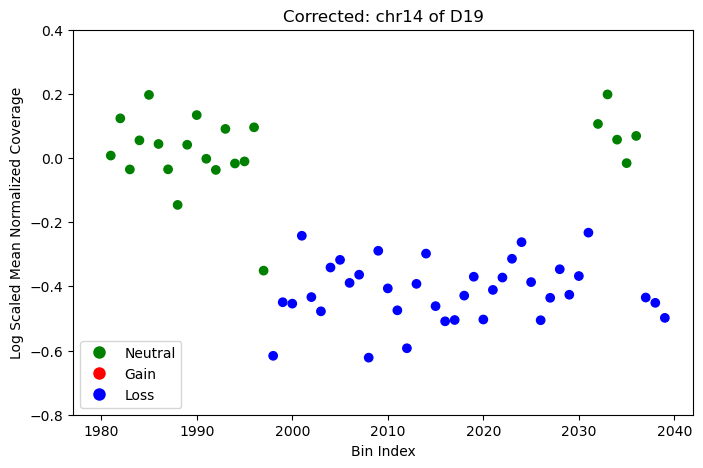

..................................................................................................................


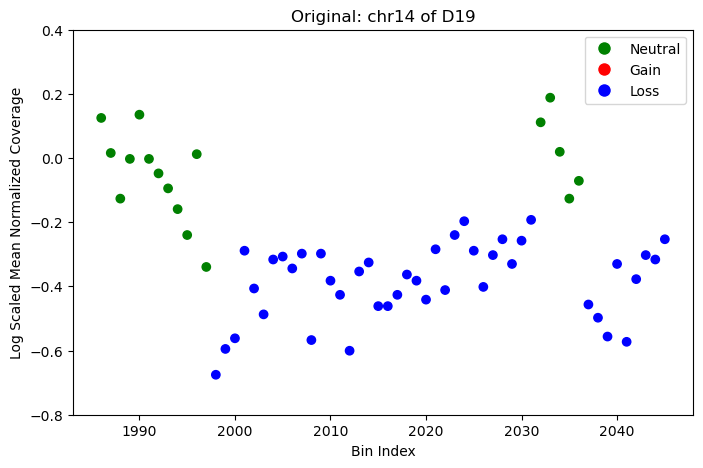

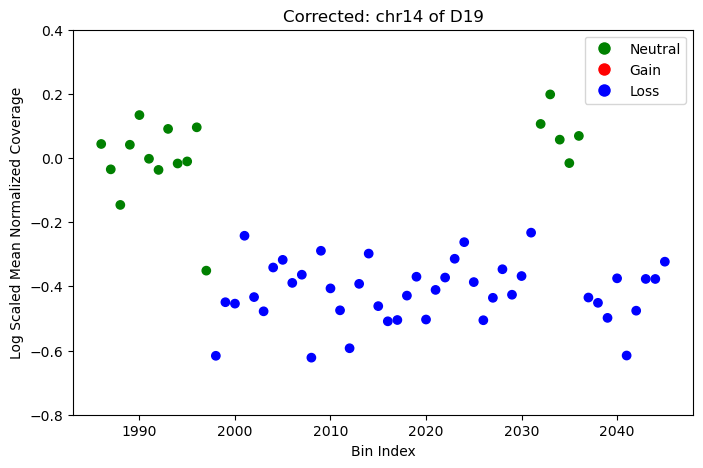

..................................................................................................................


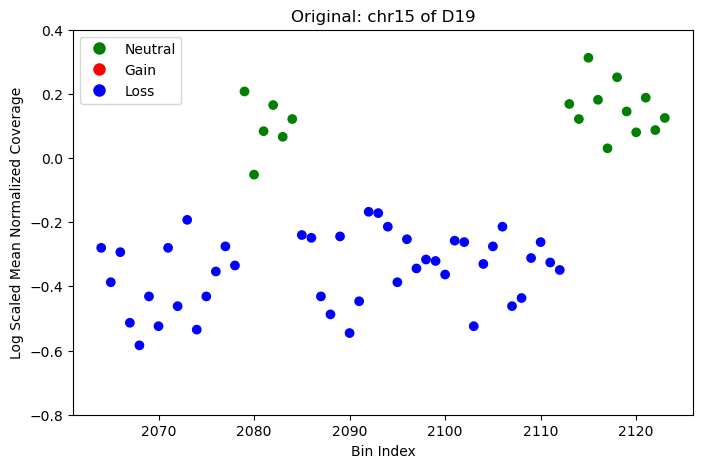

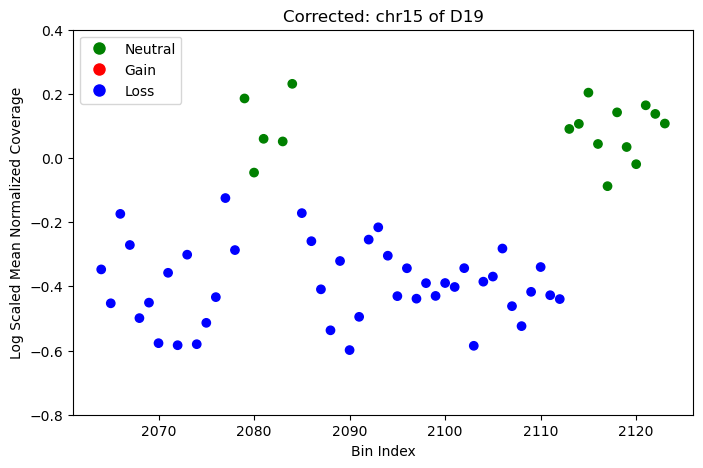

..................................................................................................................


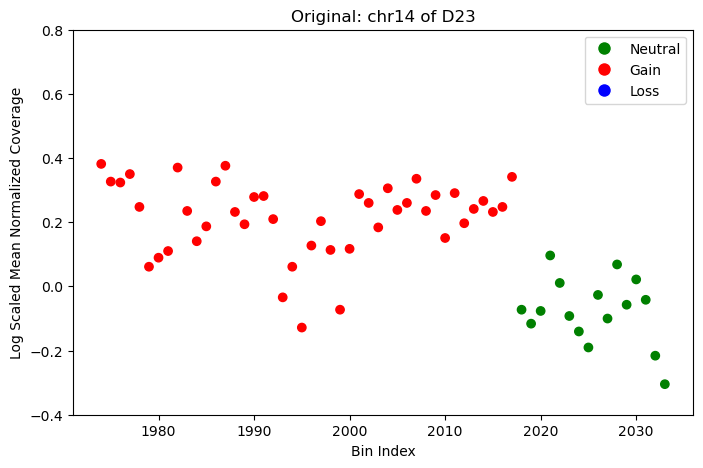

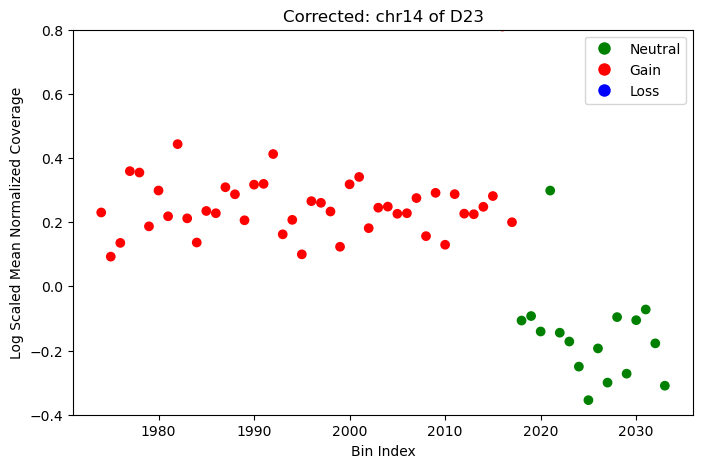

..................................................................................................................


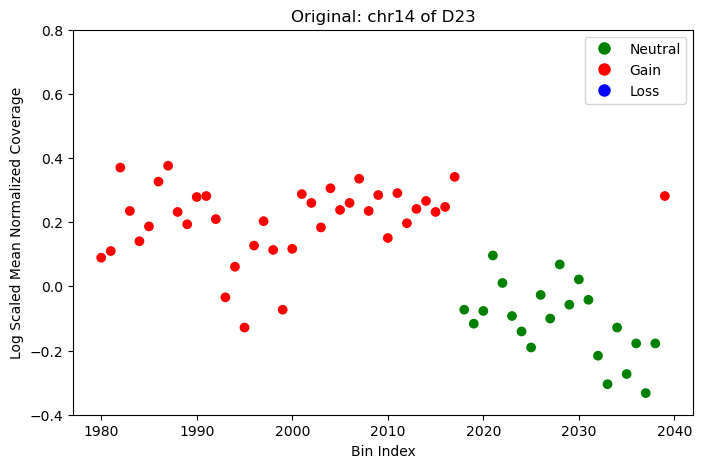

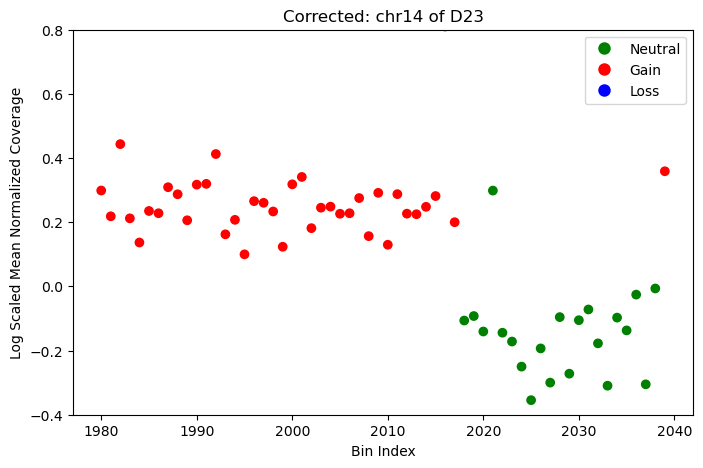

..................................................................................................................


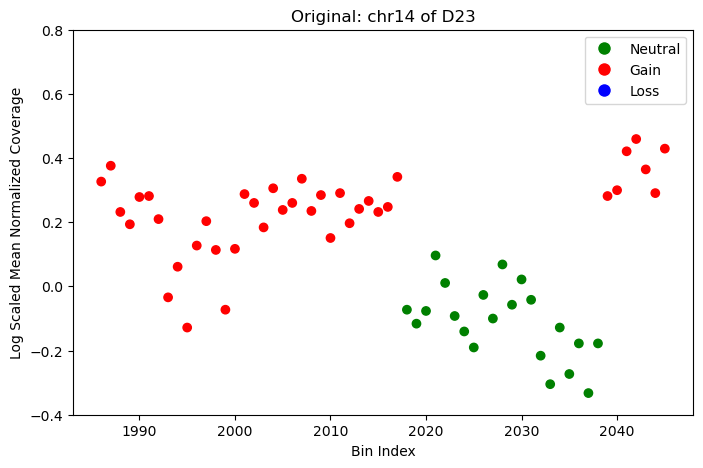

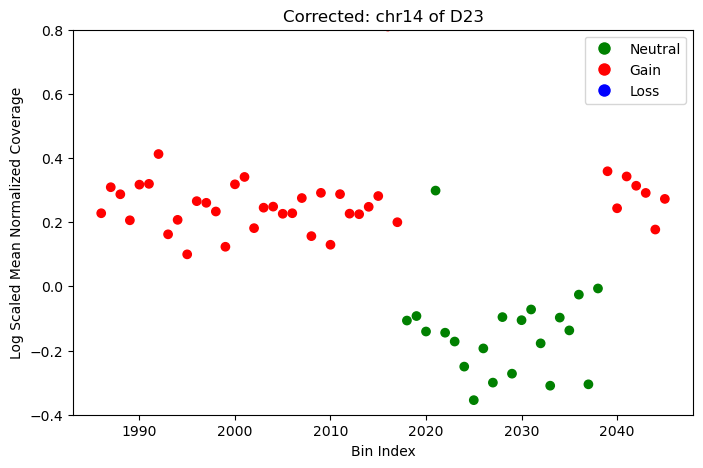

..................................................................................................................


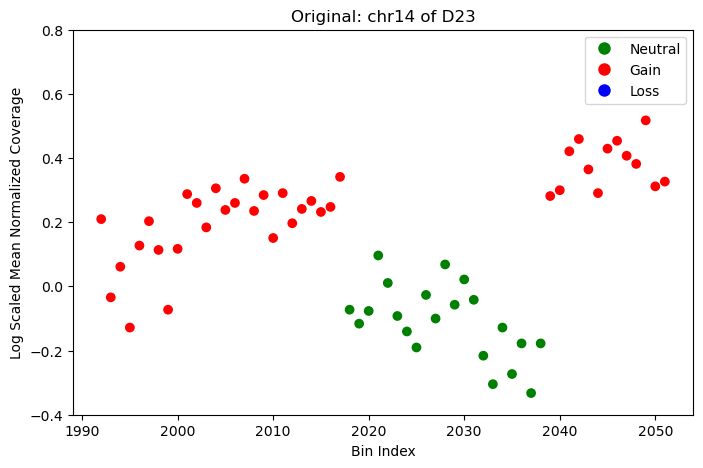

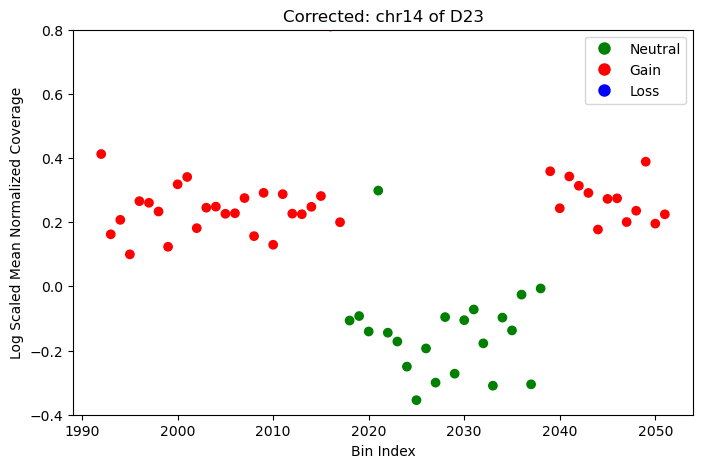

..................................................................................................................


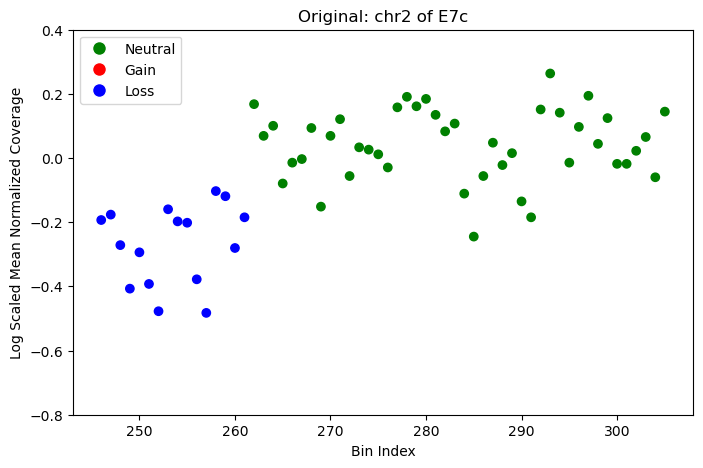

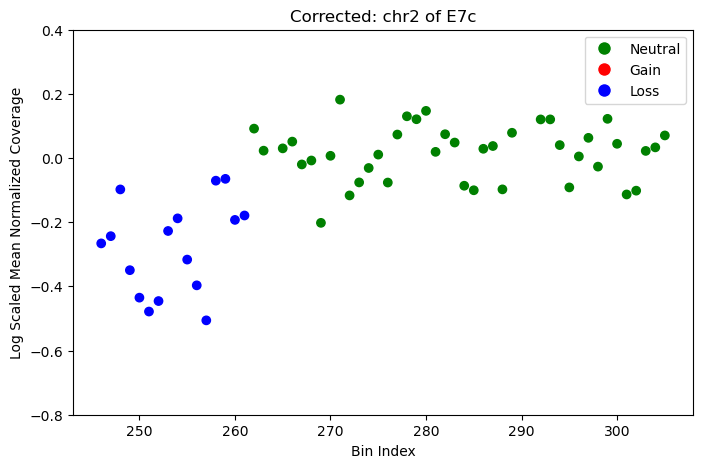

..................................................................................................................


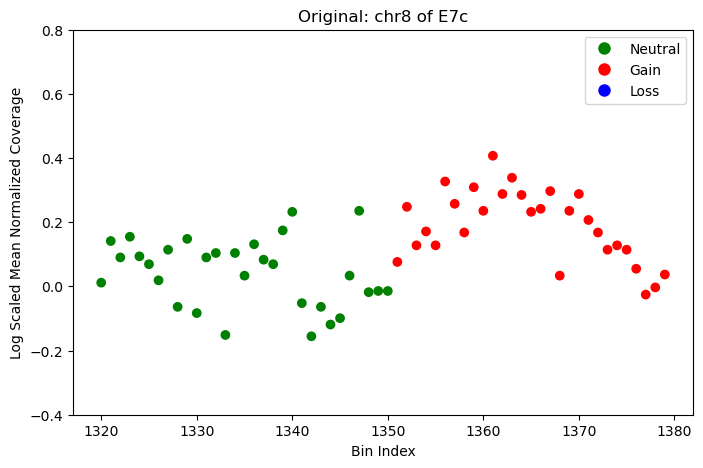

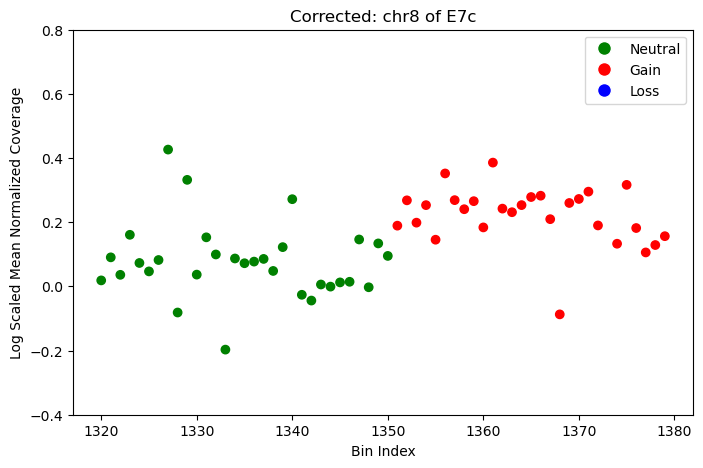

..................................................................................................................


In [6]:
count_thr = 50
crc_region_size_thr = 30
brca_region_size_thr = 60
region_size_frac_thr = 0.2
region_step_div = 10

def identify_interesting_regions(cohort, sample_name, window_size):
    global count_thr
    bin_CNA_labels = pd.read_csv(f'Bin_Label_CNA/{cohort}/{sample_name}.csv')['CNA_Label'].values.tolist()
    bin_CNA_chrs = pd.read_csv(f'Bin_Label_CNA/{cohort}/{sample_name}.csv')['Contig'].values.tolist()
    interesting_windows = []
    step_size = int(window_size/region_step_div)
    thr = int(window_size * region_size_frac_thr)
    sample = np.load(f'1Mb_2K_bins/Original/{cohort}/{sample_name}.npy')
    for i in range(0, len(bin_CNA_labels)-window_size+1, step_size):
        start, end = i, i+window_size-1
        start_chr, end_chr = bin_CNA_chrs[start], bin_CNA_chrs[end]
        min_count = np.min( sample[start : end+1] )
        if start_chr==end_chr and min_count>count_thr:
            window_CNA_labels = bin_CNA_labels[start : end+1]
            neutral_no = window_CNA_labels.count('Neutral')
            gain_no = window_CNA_labels.count('Gain')
            loss_no = window_CNA_labels.count('Loss')
            nan_no = window_size - (neutral_no + gain_no + loss_no)
            if nan_no==0 and ( (neutral_no>thr and gain_no>thr) or (neutral_no>thr and loss_no>thr) ):
                interesting_windows.append([cohort, sample_name, start_chr, start, end])
    return interesting_windows

def view_interesting_regions(cohort, window_size):
    files = os.listdir(f'Bin_Label_CNA/{cohort}/')
    sample_names = [file_[:-4] for file_ in files]
    interesting_region_list = []
    for sample in sample_names:
        interesting_region_list.extend( identify_interesting_regions(cohort, sample, window_size) )
    if len(interesting_region_list)>10:
        interesting_region_list = interesting_region_list[:10]
    return interesting_region_list

def get_normalized_cov(coverage):
    mean_cov = np.mean(coverage)
    norm_cov = np.log2(coverage/mean_cov + 0.0001)
    return norm_cov

def get_plot(title, bin_coverages, bin_labels, start):
    X, Y, labels = [], [], []
    for i in range(len(bin_labels)):
        X.append(start)
        Y.append(bin_coverages[i])
        labels.append(bin_labels[i])
        start += 1
    colors = {'Neutral': 'green', 'Gain': 'red', 'Loss': 'blue'}
    c = [colors[label] for label in labels]

    plt.figure(figsize=(8, 5))
    scatter = plt.scatter(X, Y, c=c, label=labels)
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
               for label, color in colors.items()]
    plt.legend(handles=handles)
    plt.title(title)
    plt.xlabel('Bin Index')
    plt.ylabel('Log Scaled Mean Normalized Coverage')
    if ('Loss' in bin_labels) and ('Gain' in bin_labels):
        plt.ylim([-0.8, 0.8])
    elif 'Loss' in bin_labels:
        plt.ylim([-0.8, 0.4])
    elif 'Gain' in bin_labels:
        plt.ylim([-0.4, 0.8])
    plt.show()

def plot_CNA(region):
    cohort, sample_name, contig, start_bin, end_bin = region[0], region[1], region[2], region[3], region[4]
    bin_CNA_labels = pd.read_csv(f'Bin_Label_CNA/{cohort}/{sample_name}.csv')['CNA_Label'].values.tolist()
    original_file = f'1Mb_2K_bins/Original/{cohort}/{sample_name}.npy'
    corrected_file = f'1Mb_2K_bins/{METHOD}_Corrected/{cohort}/{sample_name}.npy'
    original_cov = get_normalized_cov( np.load(original_file) )[start_bin: end_bin+1]
    corrected_cov = get_normalized_cov( np.load(corrected_file) )[start_bin: end_bin+1]
    region_CNA_labels = bin_CNA_labels[start_bin: end_bin+1]
    get_plot(f'Original: {contig} of {sample_name}', original_cov, region_CNA_labels, start_bin)
    get_plot(f'Corrected: {contig} of {sample_name}', corrected_cov, region_CNA_labels, start_bin)
    print('..................................................................................................................')

interesting_region_list = []
interesting_region_list.extend( view_interesting_regions('CRC_gis', crc_region_size_thr) )
interesting_region_list.extend( view_interesting_regions('BRCA_gis', brca_region_size_thr) )
for region in interesting_region_list:
    plot_CNA(region)

# Healthy All Fragment Lengths Coverage Profile Visualization

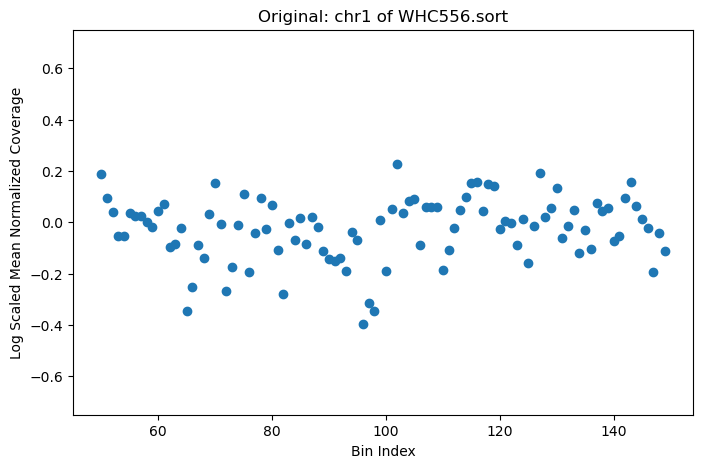

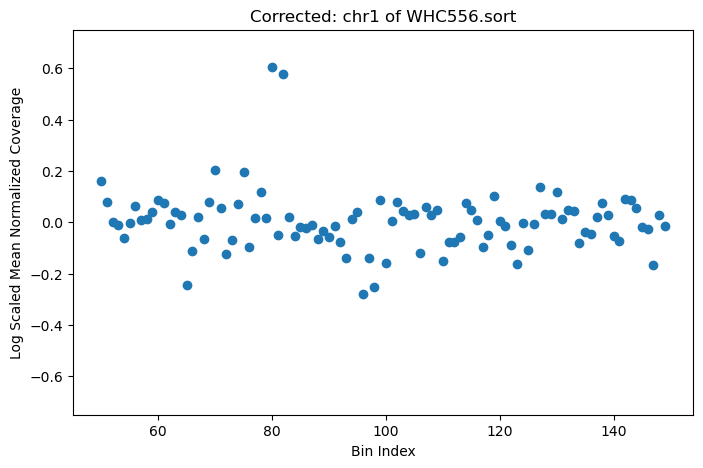

..................................................................................................................


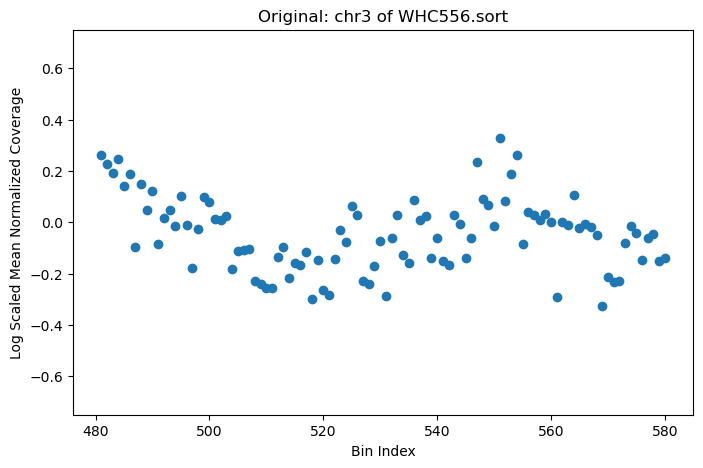

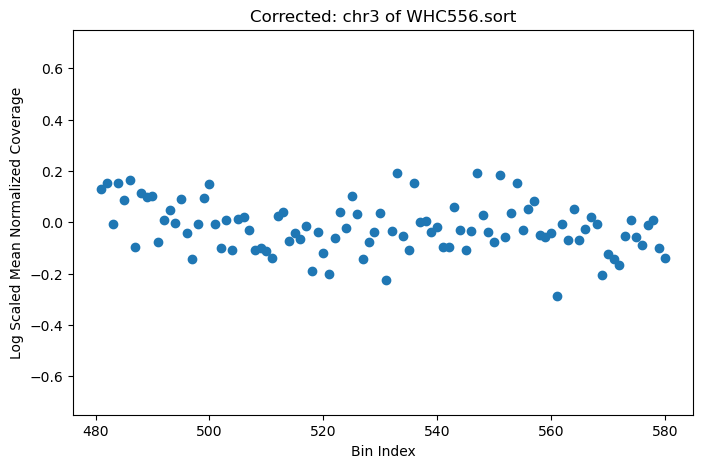

..................................................................................................................


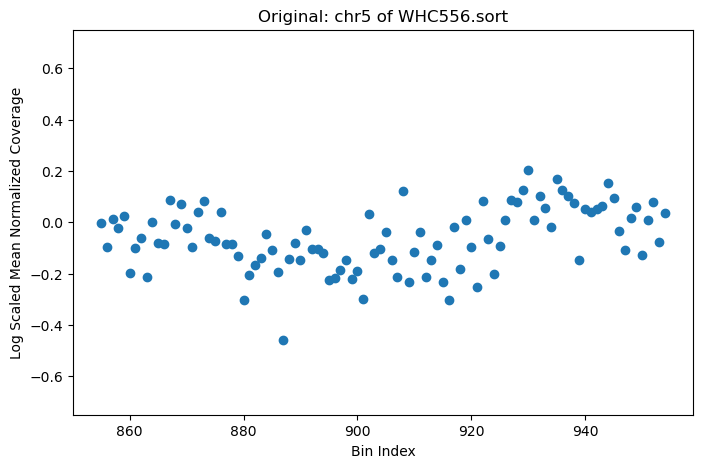

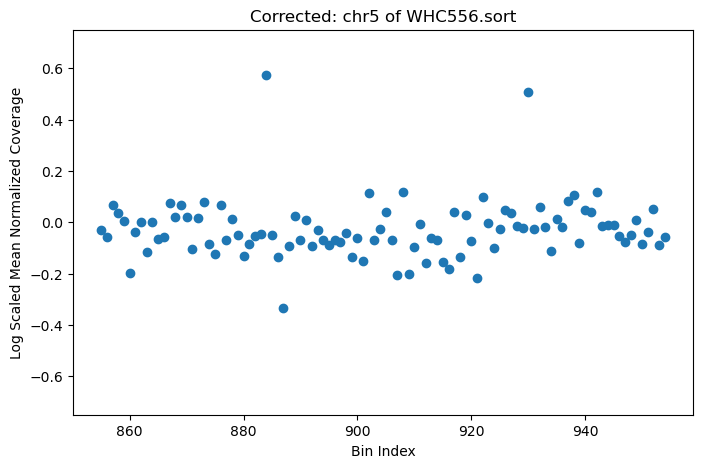

..................................................................................................................


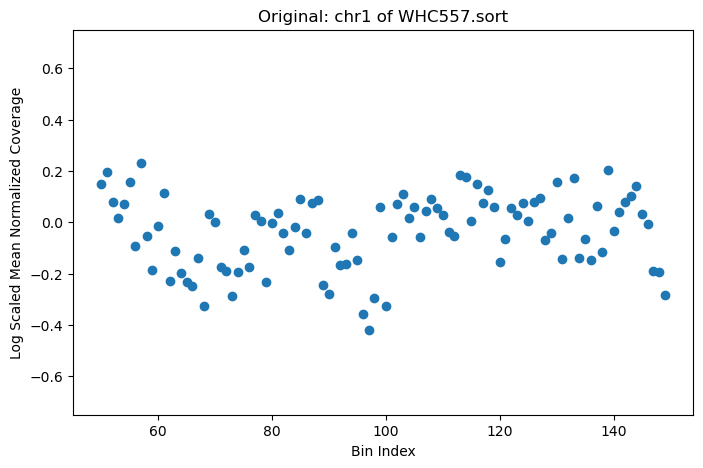

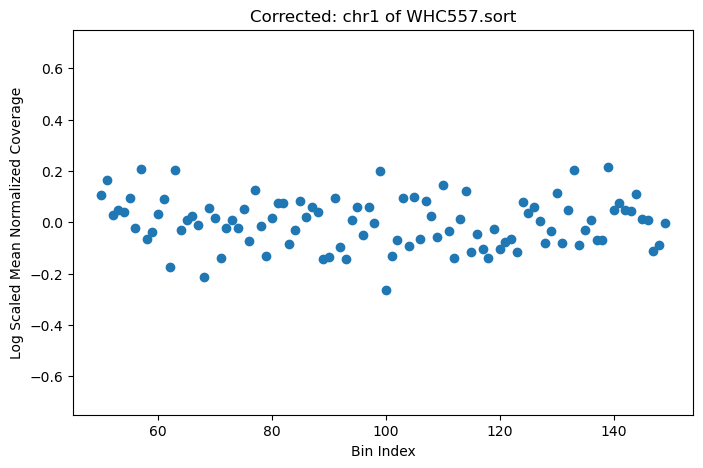

..................................................................................................................


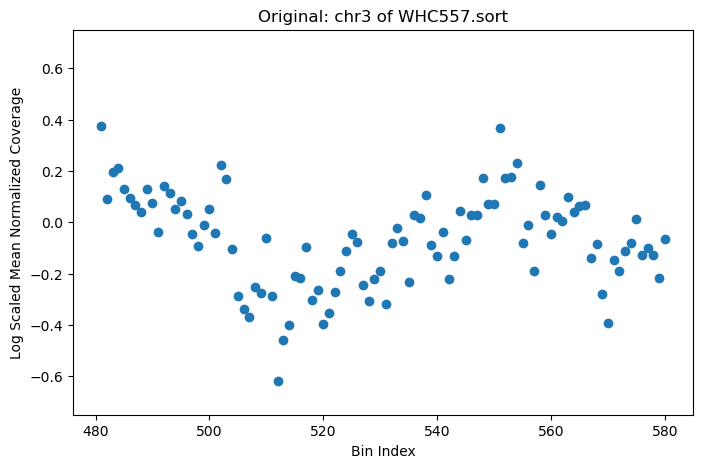

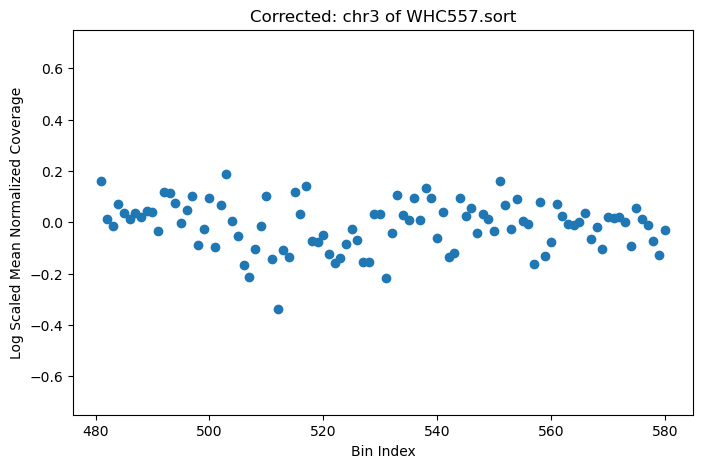

..................................................................................................................


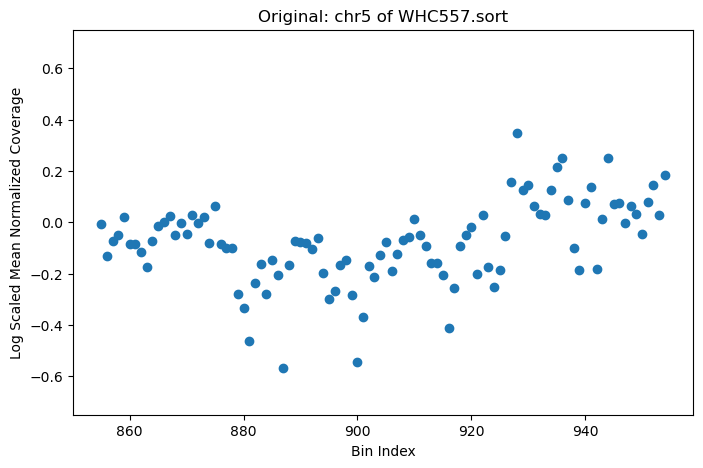

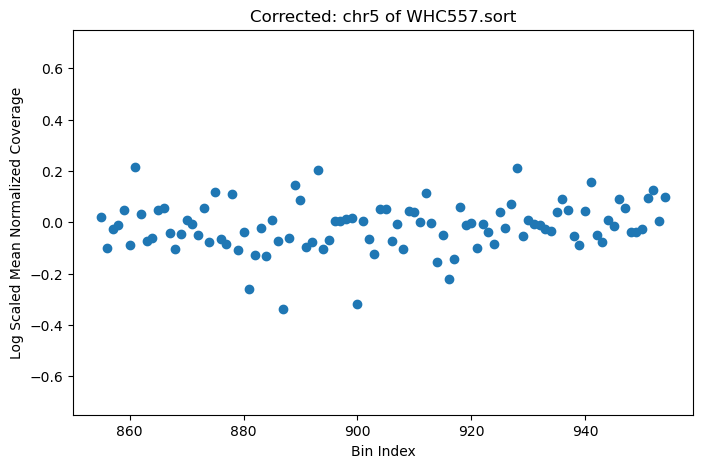

..................................................................................................................


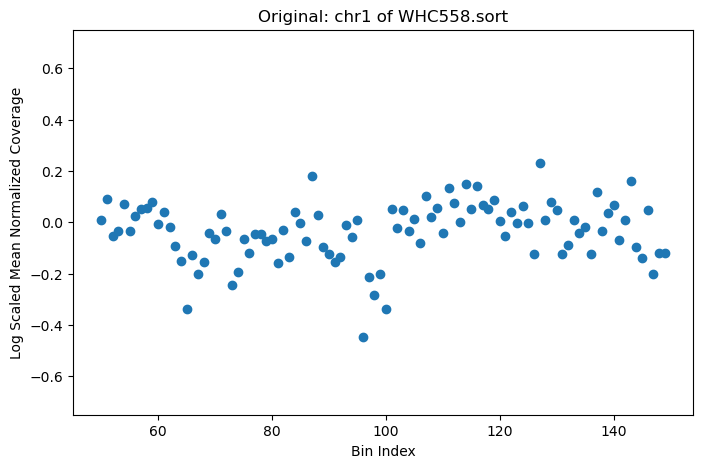

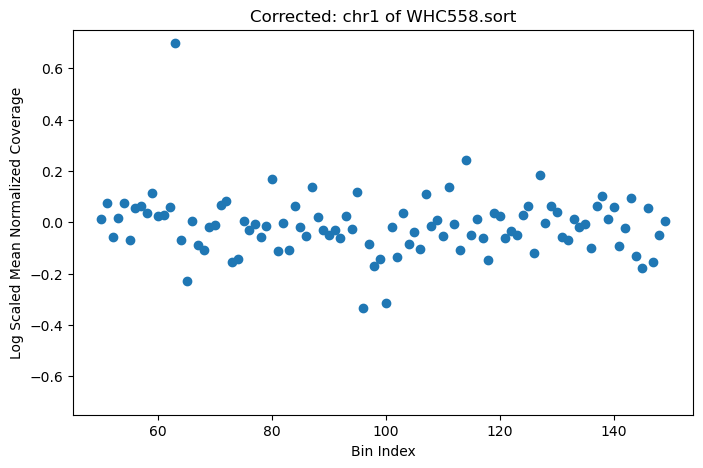

..................................................................................................................


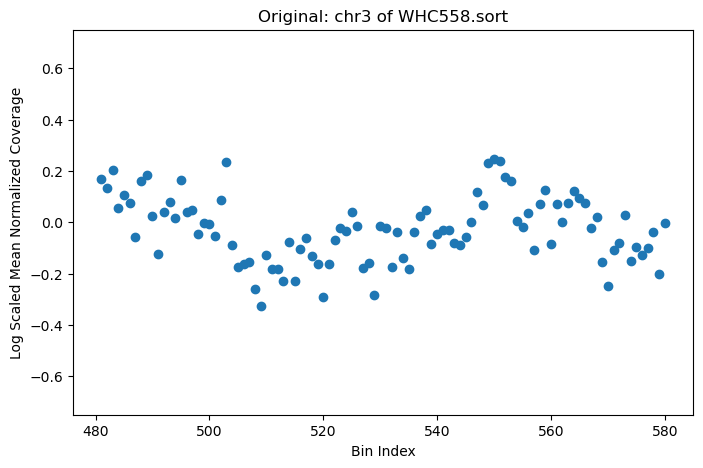

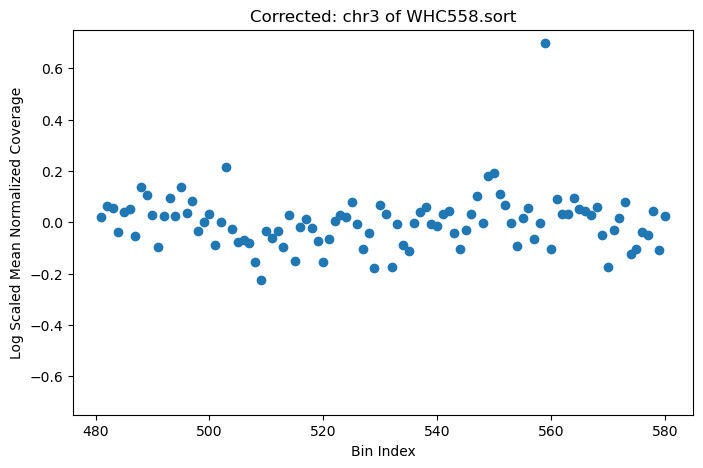

..................................................................................................................


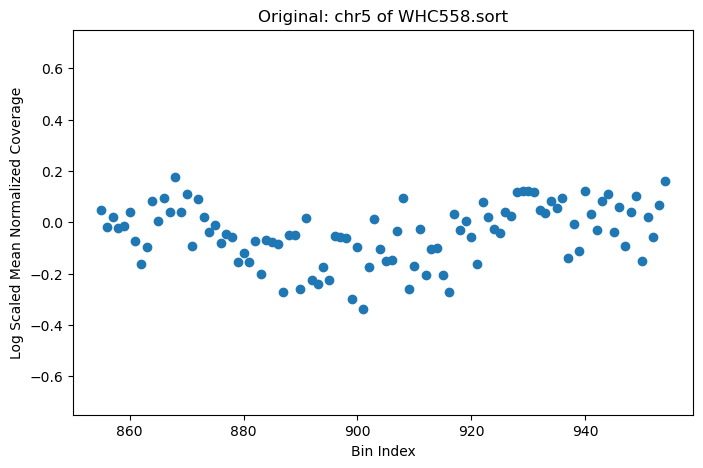

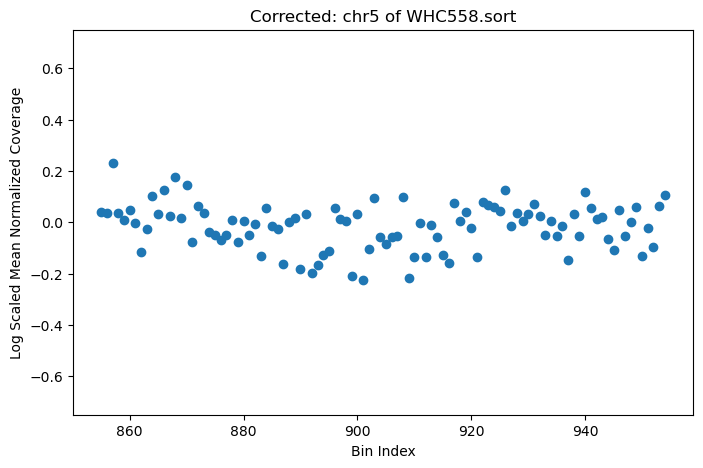

..................................................................................................................


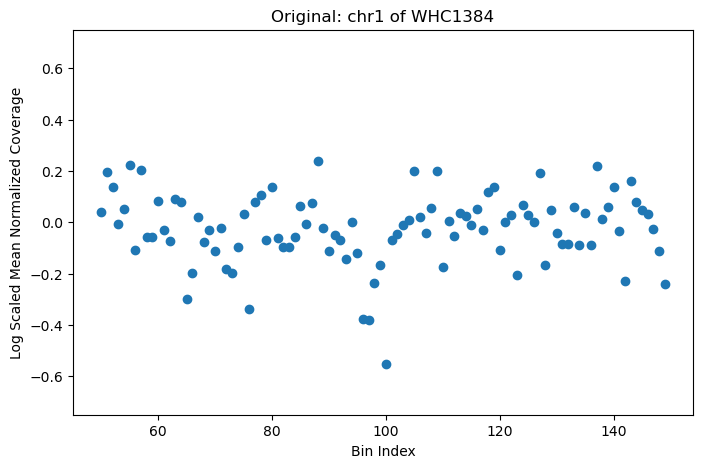

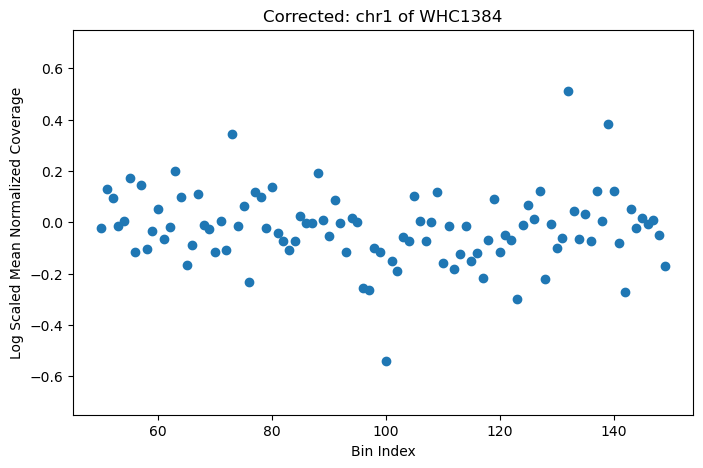

..................................................................................................................


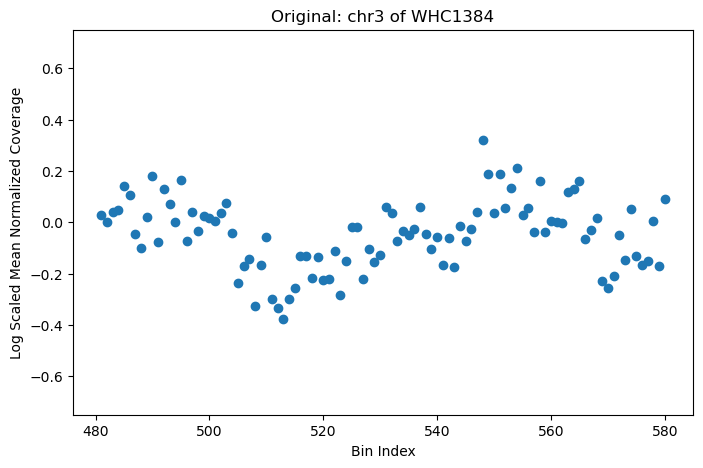

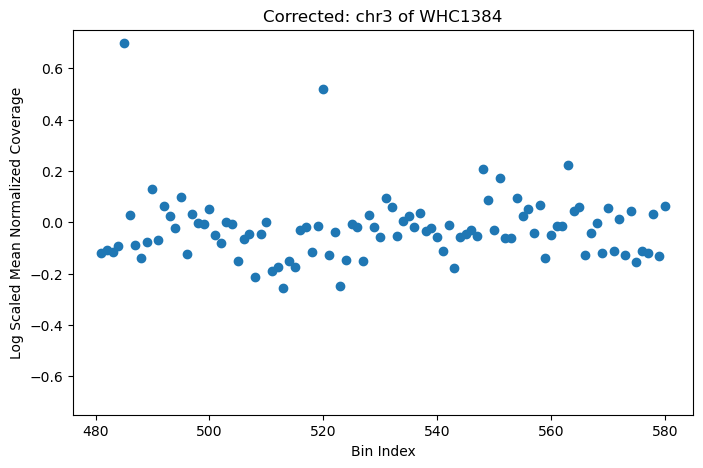

..................................................................................................................


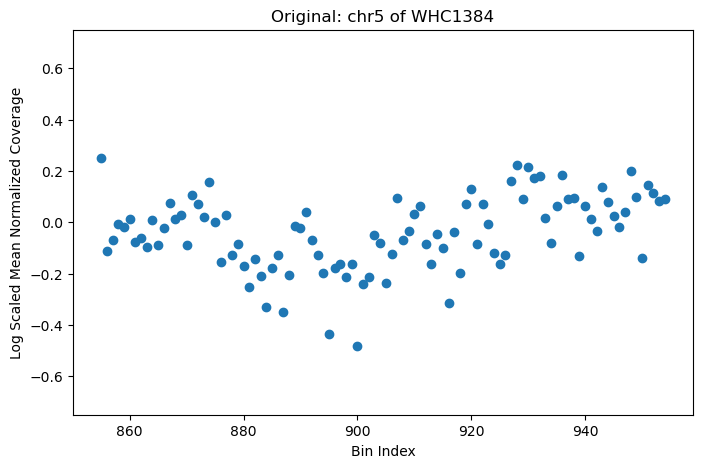

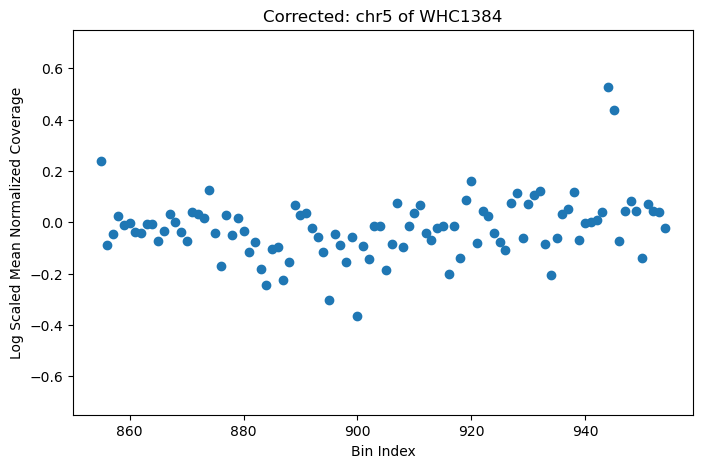

..................................................................................................................


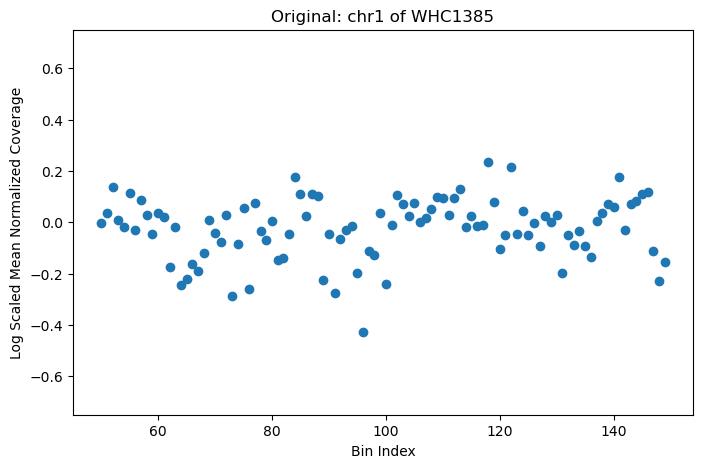

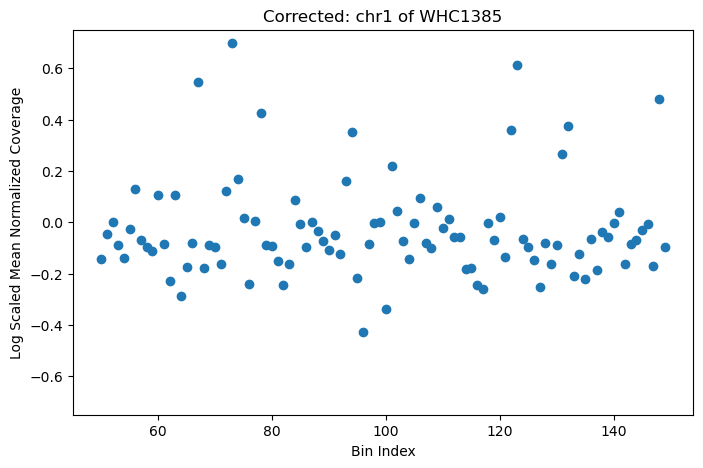

..................................................................................................................


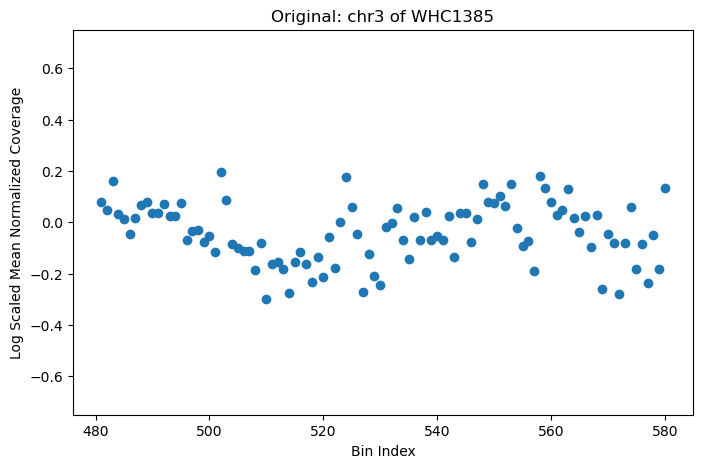

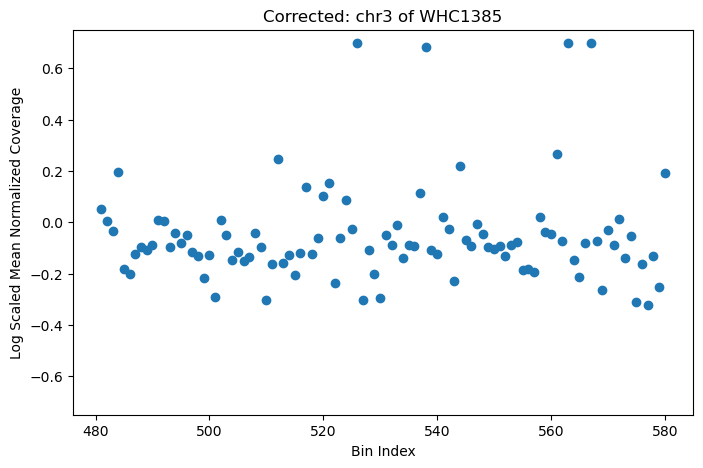

..................................................................................................................


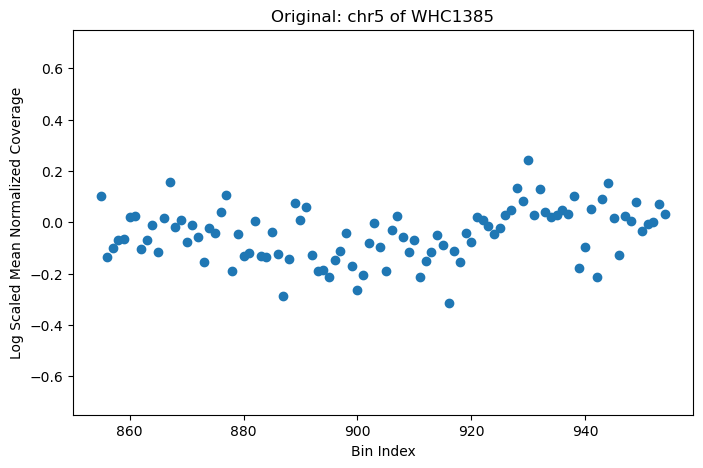

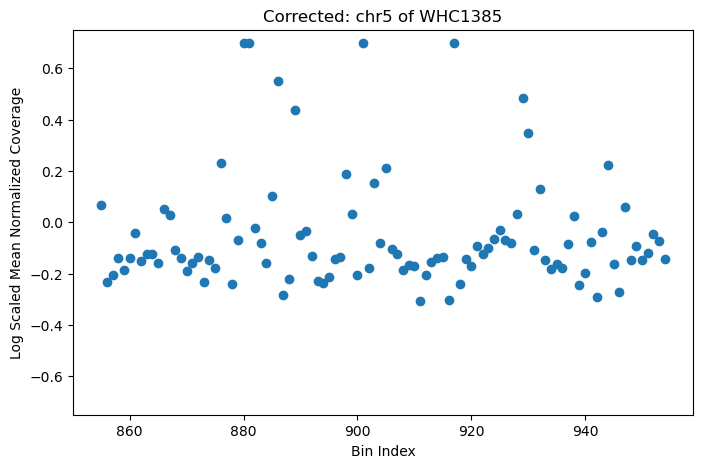

..................................................................................................................


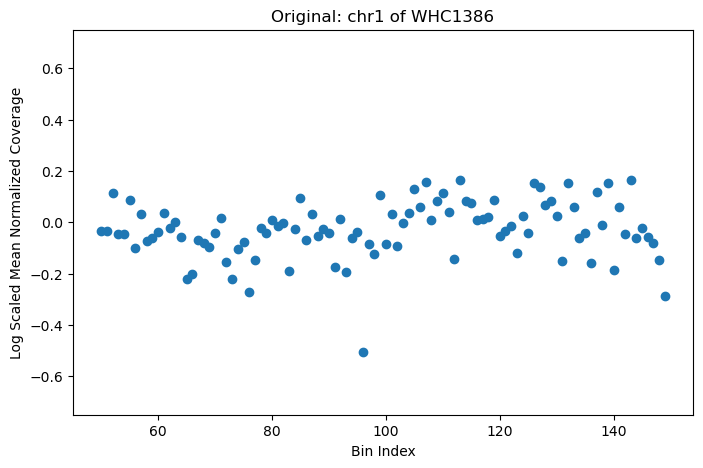

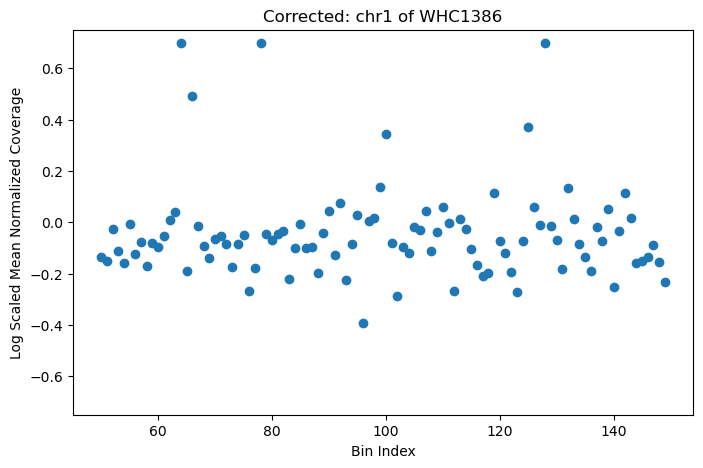

..................................................................................................................


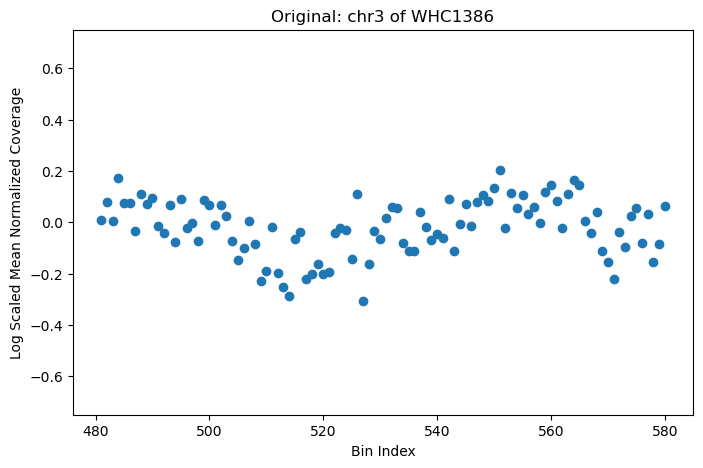

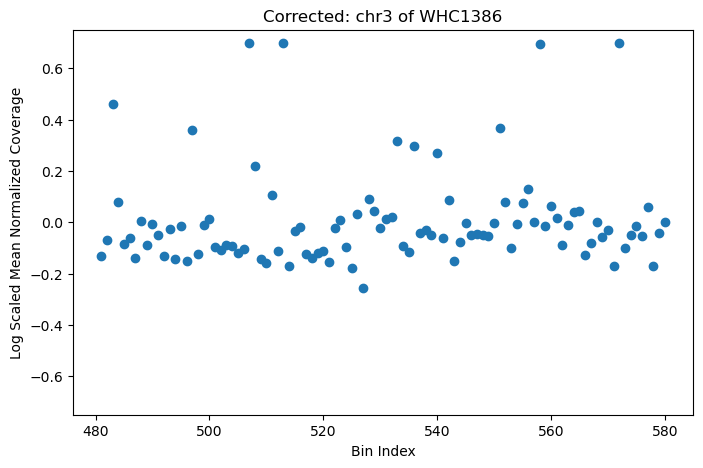

..................................................................................................................


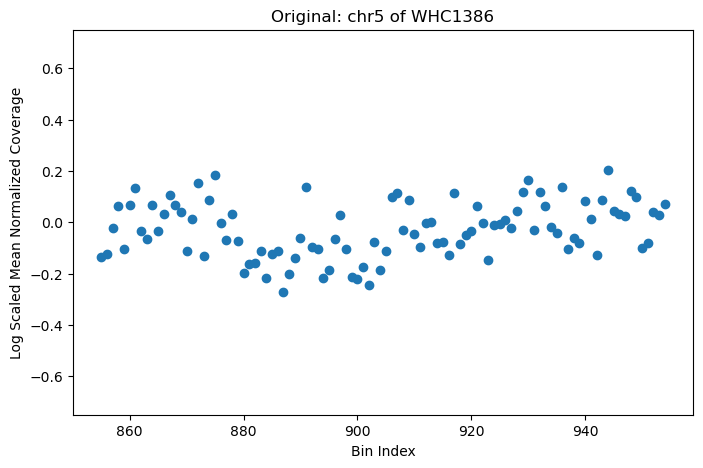

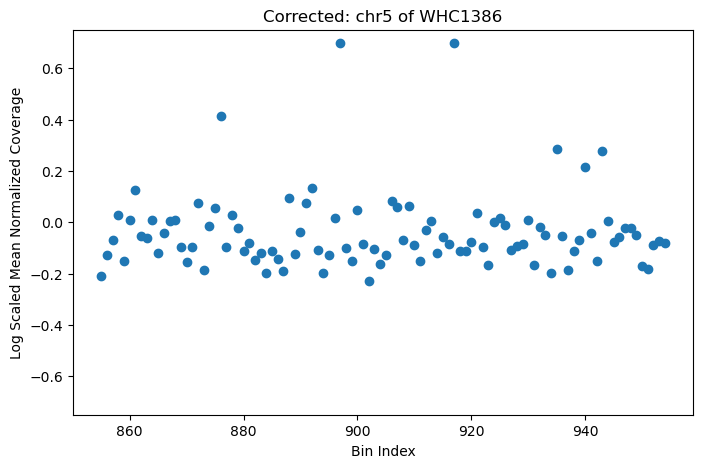

..................................................................................................................


In [4]:
bin_locations = pd.read_csv('Bin_Label_CNA/1Mb.csv').values.tolist()
window_size = 100
start_offset = 50
window_size_frac_thr = 0.1
count_thr = 50

def find_region(contig, sample):
    global window_size, start_offset, window_size_frac_thr, count_thr
    step_size = int(window_size * window_size_frac_thr)
    start = None
    for i in range(len(bin_locations)):
        if bin_locations[i][0]==contig:
            start = i + start_offset
            break
    for i in range(start, sample.shape[0], step_size):
        min_total_count = np.min( sample[i: i+window_size] )
        if min_total_count>count_thr:
            start = i
            end = i+window_size-1
            return start, end

def identify_interesting_regions(cohort, sample_name):
    contigs = ['chr1', 'chr3', 'chr5']
    sample = np.load(f'1Mb_2K_bins/Original/{cohort}/{sample_name}.npy')
    interesting_windows = []
    for contig in contigs:
        start, end = find_region(contig, sample)
        interesting_windows.append([cohort, sample_name, contig, start, end])
    return interesting_windows

def view_interesting_regions(cohort):
    files = os.listdir(f'1Mb_2K_bins/Original/{cohort}/')
    sample_names = [file_[:-4] for file_ in files[:3]]
    interesting_region_list = []
    for sample in sample_names:
        interesting_region_list.extend( identify_interesting_regions(cohort, sample) )
    return interesting_region_list

def get_normalized_cov(coverage):
    mean_cov = np.mean(coverage)
    norm_cov = np.log2(coverage/mean_cov + 0.0001)
    norm_cov[norm_cov > 0.7] = 0.7
    norm_cov[norm_cov < -0.7] = -0.7
    return norm_cov

def get_plot(title, bin_coverages, start, end):
    X, Y = [], []
    for i in range(start, end+1):
        X.append(i)
        Y.append(bin_coverages[i-start])
    plt.figure(figsize=(8, 5))
    scatter = plt.scatter(X, Y)
    plt.title(title)
    plt.xlabel('Bin Index')
    plt.ylabel('Log Scaled Mean Normalized Coverage')
    plt.ylim([-0.75, 0.75])
    plt.show()

def plot_CNA(region):
    cohort, sample_name, contig, start_bin, end_bin = region[0], region[1], region[2], region[3], region[4]
    original_file = f'1Mb_2K_bins/Original/{cohort}/{sample_name}.npy'
    corrected_file = f'1Mb_2K_bins/{METHOD}_Corrected/{cohort}/{sample_name}.npy'
    original_cov = get_normalized_cov( np.load(original_file) )[start_bin: end_bin+1]
    corrected_cov = get_normalized_cov( np.load(corrected_file) )[start_bin: end_bin+1]
    get_plot(f'Original: {contig} of {sample_name}', original_cov, start_bin, end_bin)
    get_plot(f'Corrected: {contig} of {sample_name}', corrected_cov, start_bin, end_bin)
    print('..................................................................................................................')

interesting_region_list = []
interesting_region_list.extend( view_interesting_regions('healthy_c2i') )
interesting_region_list.extend( view_interesting_regions('healthy_invitro') )
for region in interesting_region_list:
    plot_CNA(region)

# Coefficient of Variance: 
### (1) Original CV Extraction
### (2) Valid Window List Extraction
### Run this portion only once for a single lpWGS coverage

In [11]:
CV_dic = {}
valid_window_dic = {}

### Cancer Sample

In [12]:
run_size = 10
run_step_div = 2
min_count_thr = 50

def is_valid_window(bin_CNA_labels, start, end):
    window_CNA_labels = bin_CNA_labels[start : end+1]
    neutral_no = window_CNA_labels.count('Neutral')
    gain_no = window_CNA_labels.count('Gain')
    loss_no = window_CNA_labels.count('Loss')
    nan_no = len(window_CNA_labels) - (neutral_no + gain_no + loss_no)
    if nan_no==0:
        if neutral_no!=0 and gain_no==0 and loss_no==0:
            return True
        elif neutral_no==0 and gain_no!=0 and loss_no==0:
            return True
        elif neutral_no==0 and gain_no==0 and loss_no!=0:
            return True
    return False

def get_normalized_cov(coverage):
    mean_cov = np.mean(coverage)
    norm_cov = coverage/mean_cov
    return norm_cov

def get_CV(sample, start, end):
    mean = np.mean(sample[start: end+1]) + 0.000001
    std = np.std(sample[start: end+1])
    return abs(std/mean)

def get_sample_CVs(cohort, sample_name, window_size):
    global run_step_div, min_count_thr 
    bin_CNA_labels = pd.read_csv(f'Bin_Label_CNA/{cohort}/{sample_name}.csv')['CNA_Label'].values.tolist()
    bin_CNA_chrs = pd.read_csv(f'Bin_Label_CNA/{cohort}/{sample_name}.csv')['Contig'].values.tolist()
    CV_list, window_list = [], []
    step_size = int(window_size/run_step_div)
    sample = np.load(f'1Mb_2K_bins/Original/{cohort}/{sample_name}.npy')
    sample_norm = get_normalized_cov(sample)
    count_thr = min( max(min_count_thr, np.percentile(sample, 1)), min_count_thr*2 )
    for i in range(0, len(bin_CNA_labels)-window_size+1, step_size):
        start, end = i, i+window_size-1
        start_chr, end_chr = bin_CNA_chrs[start], bin_CNA_chrs[end]
        min_count = np.min( sample[start : end+1] )
        if start_chr==end_chr and min_count>count_thr and is_valid_window(bin_CNA_labels, start, end)==True:
            CV_list.append( get_CV(sample_norm, start, end) )
            window_list.append( [start, end] )
    return CV_list, window_list

cancer_cohorts = ['BRCA_gis', 'CRC_gis']
for cohort in cancer_cohorts:
    files = os.listdir(f'1Mb_2K_bins/Original/{cohort}/')
    sample_names = [file_[:-4] for file_ in files]
    for sample_name in sample_names:
        CVs, windows = get_sample_CVs(cohort, sample_name, run_size)
        CV_dic[sample_name] = CVs
        valid_window_dic[sample_name] = windows

### Healthy Sample

In [13]:
def get_normalized_cov(coverage):
    mean_cov = np.mean(coverage)
    norm_cov = coverage/mean_cov
    return norm_cov

def get_CV(sample, start, end):
    mean = np.mean(sample[start: end+1]) + 0.000001
    std = np.std(sample[start: end+1])
    return abs(std/mean)

def get_sample_CVs(cohort, sample_name, window_size):
    bin_locations = pd.read_csv('Bin_Label_CNA/1Mb.csv').values.tolist()
    CV_list, window_list = [], []
    step_size = int(window_size/run_step_div)
    sample = np.load(f'1Mb_2K_bins/Original/{cohort}/{sample_name}.npy')
    sample_norm = get_normalized_cov(sample)
    count_thr = min( max(min_count_thr, np.percentile(sample, 1)), min_count_thr*2 )
    for i in range(0, sample.shape[0]-window_size+1, step_size):
        start, end = i, i+window_size-1
        start_chr, end_chr = bin_locations[start][0], bin_locations[end][0]
        min_count = np.min( sample[start : end+1] )
        if start_chr==end_chr and min_count>count_thr:
            CV_list.append( get_CV(sample_norm, start, end) )
            window_list.append( [start, end] )
    return CV_list, window_list

healthy_cohorts = ['healthy_c2i', 'healthy_invitro']
for cohort in healthy_cohorts:
    files = os.listdir(f'1Mb_2K_bins/Original/{cohort}/')
    sample_names = [file_[:-4] for file_ in files]
    for sample_name in sample_names:
        CVs, windows = get_sample_CVs(cohort, sample_name, run_size)
        CV_dic[sample_name] = CVs
        valid_window_dic[sample_name] = windows

In [14]:
for key in CV_dic.keys():
    print( key, round( np.mean(CV_dic[key]), 3 ) )

D14 0.063
D19 0.076
D23 0.082
D7 0.084
D9 0.066
E10c 0.065
E2c 0.15
E6c 0.092
E7c 0.065
E8c 0.07
NCC_CRC-1014_180816-CW-T-ready 0.066
NCC_CRC-1279_221015_CW-T-ready 0.062
NCC_CRC-1279_241116_CW-T-ready 0.074
NCC_CRC-1531_160616_CW-T-ready 0.07
NCC_CRC-1531_180119_CW-T-ready 0.062
NCC_CRC-512_051015-CW-T-ready 0.064
NCC_CRC-512_130114-CW-T-ready 0.067
NCC_CRC-519_210114_CW-T-ready 0.069
NCC_CRC-809_030915-CW-T-ready 0.067
NCC_CRC-809_110914-CW-T-ready 0.08
NCC_CRC-986_100215-CW-T-ready 0.061
NCC_CRC-986_261016-CW-T-ready 0.06
WHC556.sort 0.072
WHC557.sort 0.086
WHC558.sort 0.07
WHC559.sort 0.057
WHC560.sort 0.072
WHC561.sort 0.081
WHC562.sort 0.066
WHC563.sort 0.062
WHC564.sort 0.067
WHC565.sort 0.068
WHC566.sort 0.07
WHC567.sort 0.066
WHC568.sort 0.063
WHC569.sort 0.059
WHC570.sort 0.076
WHC571.sort 0.065
WHC572.sort 0.1
WHC1384 0.072
WHC1385 0.064
WHC1386 0.064
WHC1387 0.07
WHC1388 0.064
WHC1389 0.077
WHC1390 0.077
WHC1391 0.08
WHC1392 0.071
WHC1393 0.079
WHC1394 0.071
WHC1395 0.074


In [15]:
for key in valid_window_dic.keys():
    print(key, len(valid_window_dic[key]))

D14 246
D19 179
D23 236
D7 63
D9 131
E10c 237
E2c 173
E6c 264
E7c 223
E8c 251
NCC_CRC-1014_180816-CW-T-ready 252
NCC_CRC-1279_221015_CW-T-ready 232
NCC_CRC-1279_241116_CW-T-ready 245
NCC_CRC-1531_160616_CW-T-ready 243
NCC_CRC-1531_180119_CW-T-ready 222
NCC_CRC-512_051015-CW-T-ready 200
NCC_CRC-512_130114-CW-T-ready 244
NCC_CRC-519_210114_CW-T-ready 217
NCC_CRC-809_030915-CW-T-ready 275
NCC_CRC-809_110914-CW-T-ready 235
NCC_CRC-986_100215-CW-T-ready 232
NCC_CRC-986_261016-CW-T-ready 199
WHC556.sort 465
WHC557.sort 465
WHC558.sort 465
WHC559.sort 465
WHC560.sort 465
WHC561.sort 465
WHC562.sort 465
WHC563.sort 465
WHC564.sort 465
WHC565.sort 465
WHC566.sort 465
WHC567.sort 465
WHC568.sort 465
WHC569.sort 465
WHC570.sort 465
WHC571.sort 465
WHC572.sort 465
WHC1384 465
WHC1385 465
WHC1386 465
WHC1387 465
WHC1388 465
WHC1389 465
WHC1390 465
WHC1391 465
WHC1392 465
WHC1393 465
WHC1394 465
WHC1395 465


In [16]:
with open('Evaluation_Files/Original_CV.pkl', 'wb') as f:
    pickle.dump(CV_dic, f)

with open('Evaluation_Files/CV_windows.pkl', 'wb') as f:
    pickle.dump(valid_window_dic, f)

# Coefficient of Variance: Corrected

In [17]:
CV_dic = {}

valid_window_dic = {}
with open('Evaluation_Files/CV_windows.pkl', 'rb') as f:
    valid_window_dic = pickle.load(f)

In [18]:
def get_normalized_cov(coverage):
    mean_cov = np.mean(coverage)
    norm_cov = coverage/mean_cov
    return norm_cov

def get_CV(sample, start, end):
    mean = np.mean(sample[start: end+1]) + 0.000001
    std = np.std(sample[start: end+1])
    return abs(std/mean)

def get_sample_CVs(cohort, sample_name):
    valid_windows = valid_window_dic[sample_name]
    CV_list = []
    sample = np.load(f'1Mb_2K_bins/{METHOD}_Corrected/{cohort}/{sample_name}.npy')
    sample_norm = get_normalized_cov(sample)
    for window in valid_windows:
        start, end = window[0], window[1]
        CV_list.append( get_CV(sample_norm, start, end) )
    return CV_list

for cohort in cohorts:
    files = os.listdir(f'1Mb_2K_bins/{METHOD}_Corrected/{cohort}/')
    sample_names = [file_[:-4] for file_ in files]
    for sample_name in sample_names:
        CV_dic[sample_name] = get_sample_CVs(cohort, sample_name)

In [19]:
with open(f'Evaluation_Files/{METHOD}/CV.pkl', 'wb') as f:
    pickle.dump(CV_dic, f)

# Corrected CV VS Original CV Correlation Plot

In [20]:
method_CV_dic, original_CV_dic = {}, {}
with open(f'Evaluation_Files/{METHOD}/CV.pkl', 'rb') as f:
    method_CV_dic = pickle.load(f)
with open('Evaluation_Files/Original_CV.pkl', 'rb') as f:
    original_CV_dic = pickle.load(f)

In [21]:
# def correlation_plot(sample_name):
#     plt.figure(figsize=(6, 6))
#     X, Y = np.log2(original_CV_dic[sample_name]), np.log2(method_CV_dic[sample_name])
#     plt.scatter(X, Y)
#     plt.xlabel('Original CV (log scaled)')
#     plt.ylabel('Corrected CV (log scaled)')
#     plt.title(f'{sample_name}: All Lengths')
#     min_val = min(min(X), min(Y))
#     max_val = max(max(X), max(Y))
#     plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
#     plt.show()

# for key in method_CV_dic.keys():
#     correlation_plot(key)

# Mean Corrected CV VS Mean Original CV Boxplot 

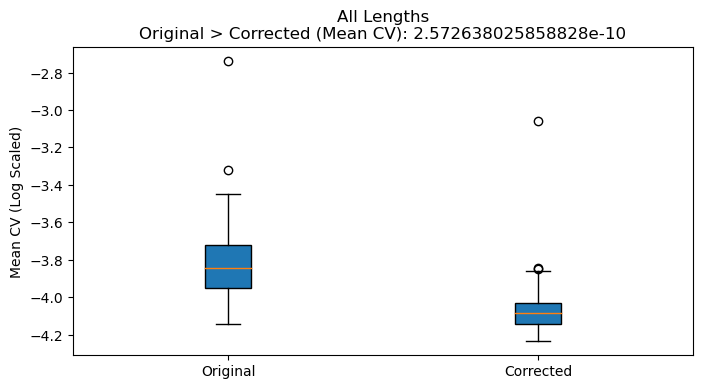

In [22]:
original_mean_CVs, correct_mean_CVs = [], []
for key in method_CV_dic.keys():
    correct_mean_CVs.append( np.log2(np.mean(method_CV_dic[key])) )
    original_mean_CVs.append( np.log2(np.mean(original_CV_dic[key])) )
data = [original_mean_CVs, correct_mean_CVs]
_, original_corrected_p = wilcoxon(data[0], data[1], alternative='greater')
plt.figure(figsize=(8, 4))
plt.boxplot(data, patch_artist=True, vert=True, labels=['Original', 'Corrected'])
plt.title(f'All Lengths\nOriginal > Corrected (Mean CV): {original_corrected_p}')
plt.ylabel('Mean CV (Log Scaled)')
plt.show()